## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-pastis-fourier-green' # Dataset Format: size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/fourier/approx1e5/green'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760,
 33: 162180}

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

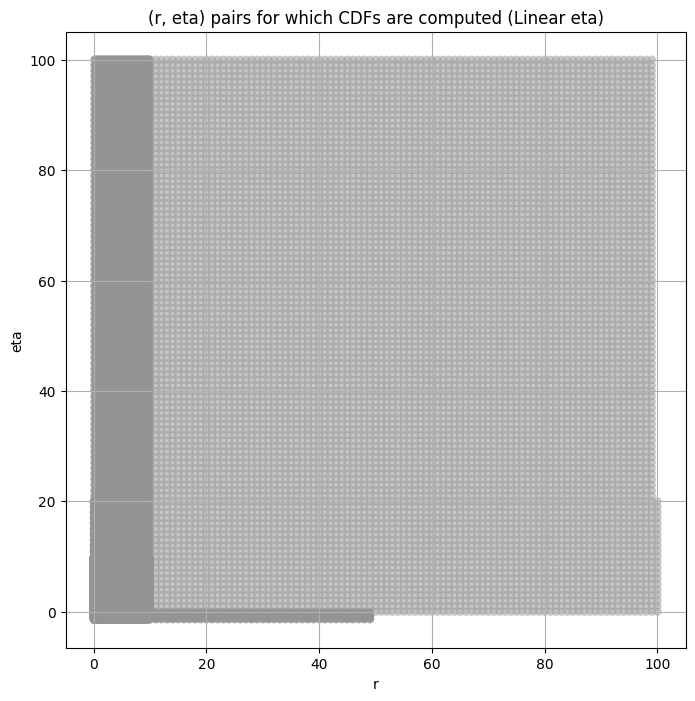

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [5]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [01:01<00:00, 1627.55it/s]


Band 5


100%|██████████| 100000/100000 [01:18<00:00, 1271.56it/s]


Band 8


100%|██████████| 100000/100000 [01:26<00:00, 1154.71it/s]


Band 11


100%|██████████| 100000/100000 [01:08<00:00, 1451.18it/s]


Band 14


100%|██████████| 100000/100000 [01:11<00:00, 1408.15it/s]


Band 17


100%|██████████| 100000/100000 [01:08<00:00, 1458.78it/s]


Band 20


100%|██████████| 100000/100000 [01:08<00:00, 1460.70it/s]


Band 23


100%|██████████| 100000/100000 [01:11<00:00, 1399.88it/s]


Band 26


100%|██████████| 100000/100000 [01:09<00:00, 1441.90it/s]


Band 29


100%|██████████| 100000/100000 [01:22<00:00, 1217.83it/s]


Band 32


100%|██████████| 100000/100000 [01:08<00:00, 1456.68it/s]


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                     
2     164622.750000  156708.31000  172875.03000   1.573100    1.155113   
5      89105.410000   84883.04000   93516.57000   1.501235    1.010971   
8      49459.945000   47133.05000   51857.87000   1.475068    1.028498   
11     28516.895000   27105.72500   29987.74800   1.817942    1.125604   
14     15809.663000   15056.35000   16603.17200   1.633317    1.063960   
17      8928.170000    8495.97900    9380.36100   1.674846    1.077402   
20      4547.406700    4326.05800    4780.43460   1.779029    1.113188   
23      2160.474900    2054.57640    2273.18460   1.860174    1.162968   
26       900.715800     848.15436     965.53920   4.115283    1.578929   
29       316.848000     290.46594     357.91980  14.169542    3.107159   
32        36.040783      34.37498      37.77347   1.344013    0.882763   

      kurt_upper  total_samples  
band                             
2       2.074450        31800.0  
5       2.142560        41340.0  
8       2.087626        66780.0  
11      2.967208       104940.0  
14      2.714023       162180.0  
17      3.061004       257580.0  
20      4.050655       381600.0  
23      3.403249       610560.0  
26     15.710218       973080.0  
29     60.432312      1376940.0  
32      2.353983       419760.0

## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 55966/55966 [01:50<00:00, 506.96it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 31800, Without approximation : 31800.0


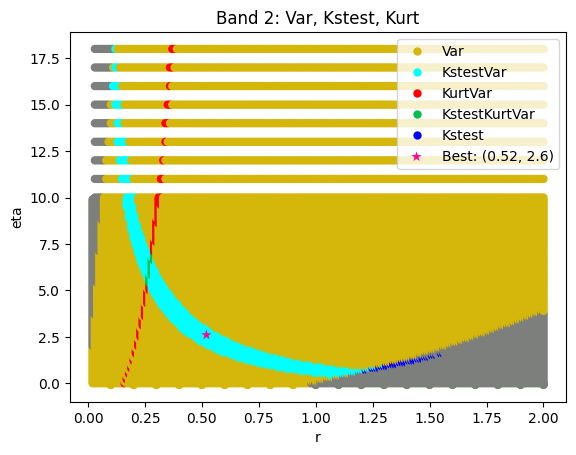

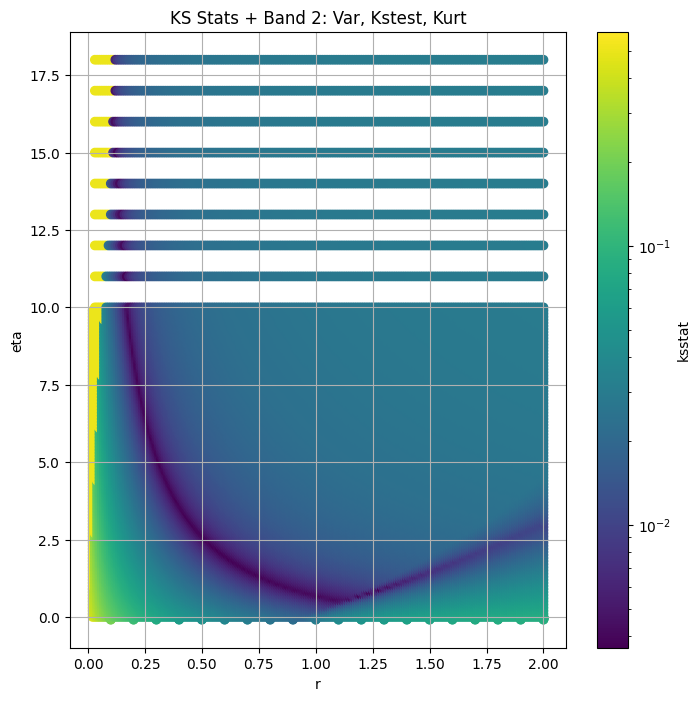

####
Band  5


100%|██████████| 55966/55966 [02:13<00:00, 419.31it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 41340, Without approximation : 41340.0


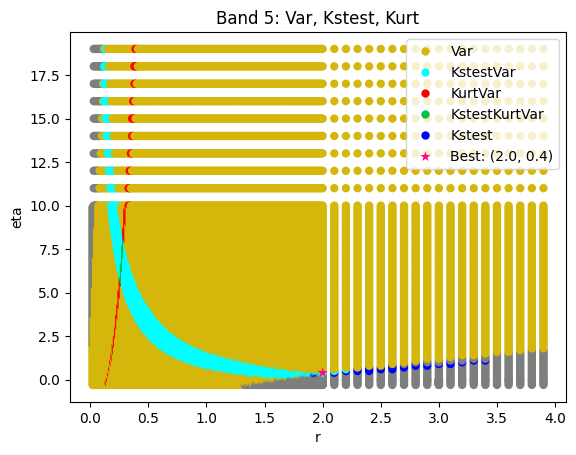

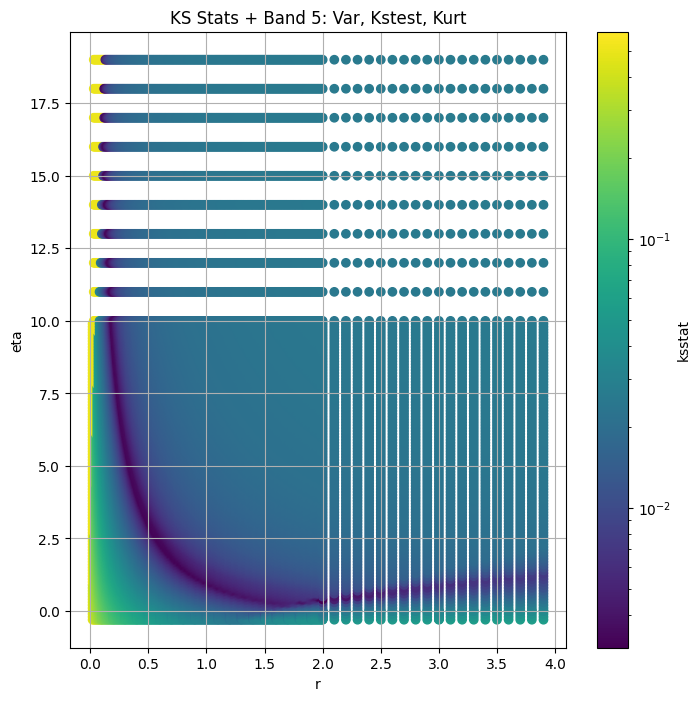

####
Band  8


100%|██████████| 55966/55966 [03:27<00:00, 269.18it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 66780, Without approximation : 66780.0


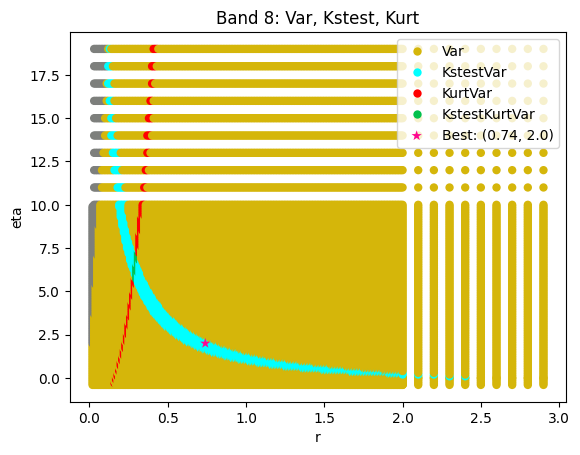

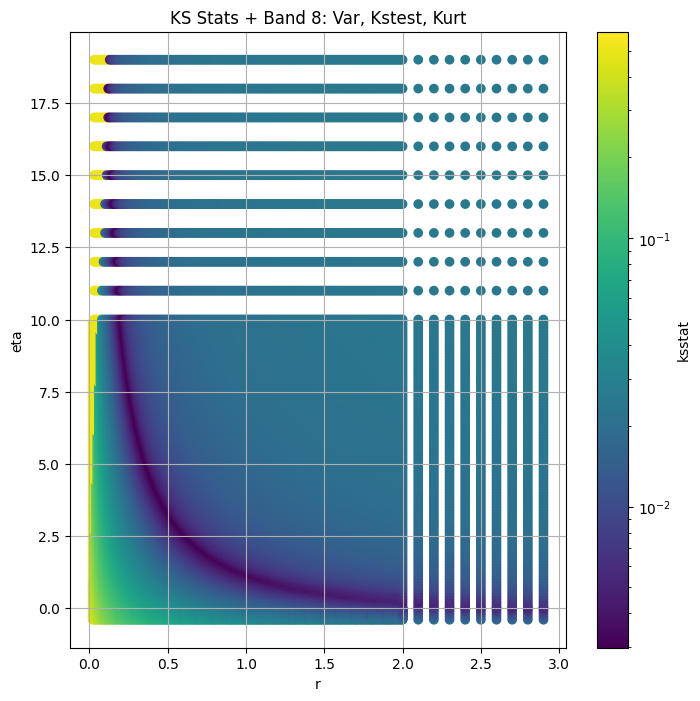

####
Band  11


100%|██████████| 55966/55966 [05:06<00:00, 182.70it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 104940.0


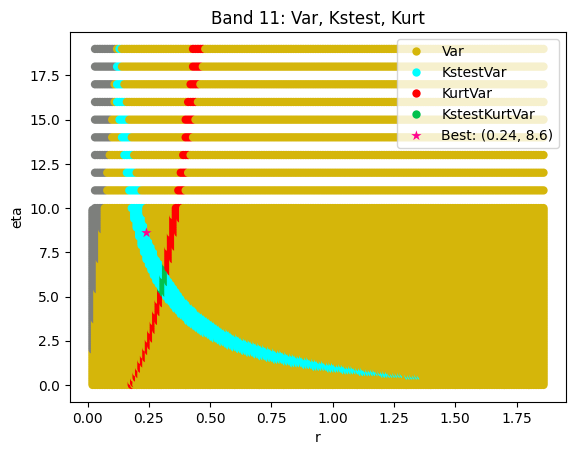

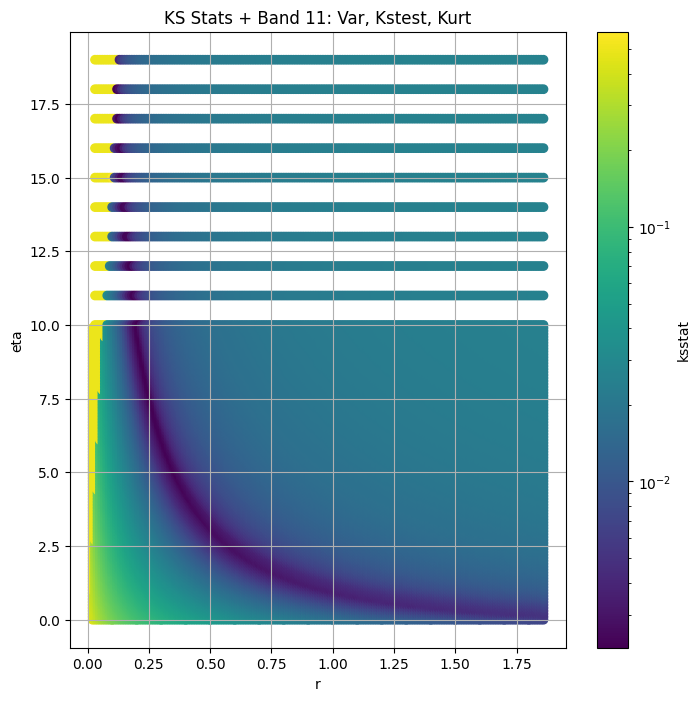

####
Band  14


100%|██████████| 55966/55966 [05:06<00:00, 182.41it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 162180.0


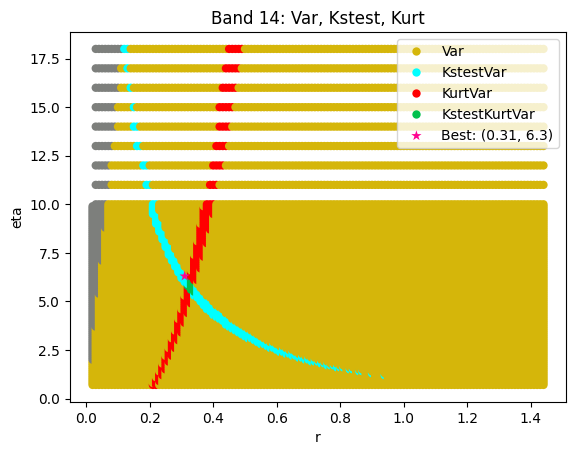

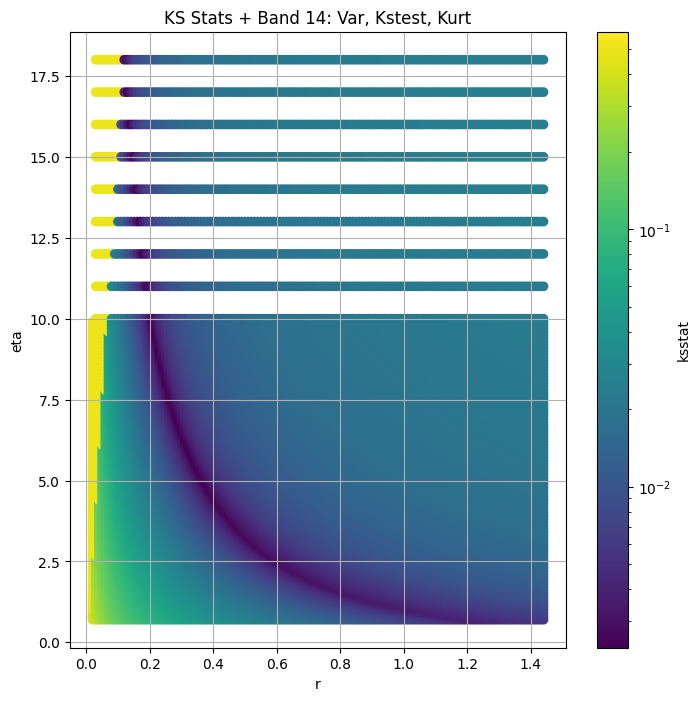

####
Band  17


100%|██████████| 55966/55966 [28:28<00:00, 32.75it/s]   


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 257580.0


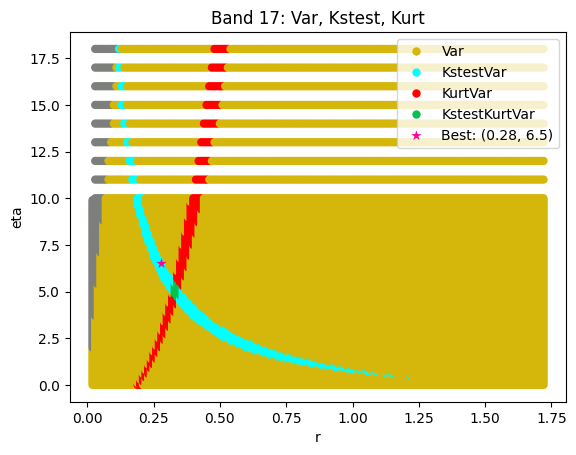

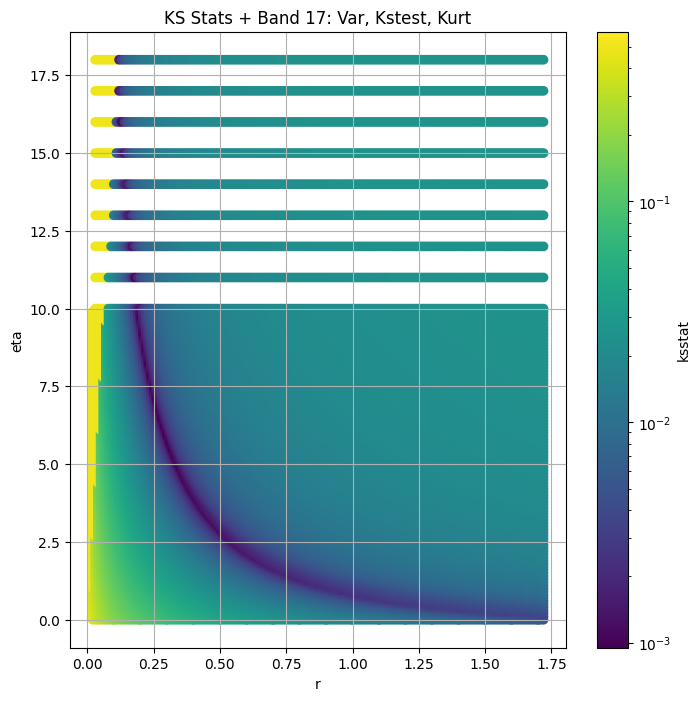

####
Band  20


100%|██████████| 55966/55966 [19:28<00:00, 47.91it/s]   


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 381600.0


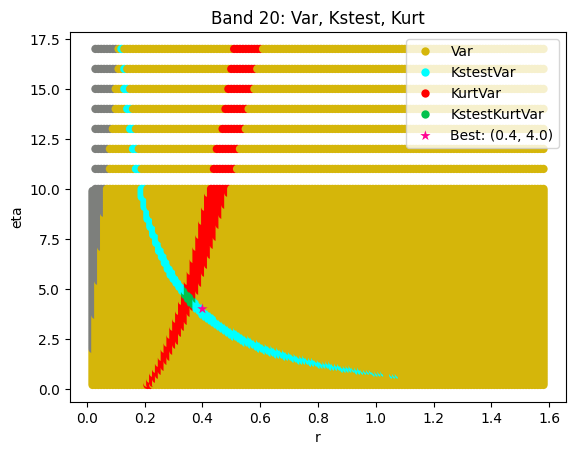

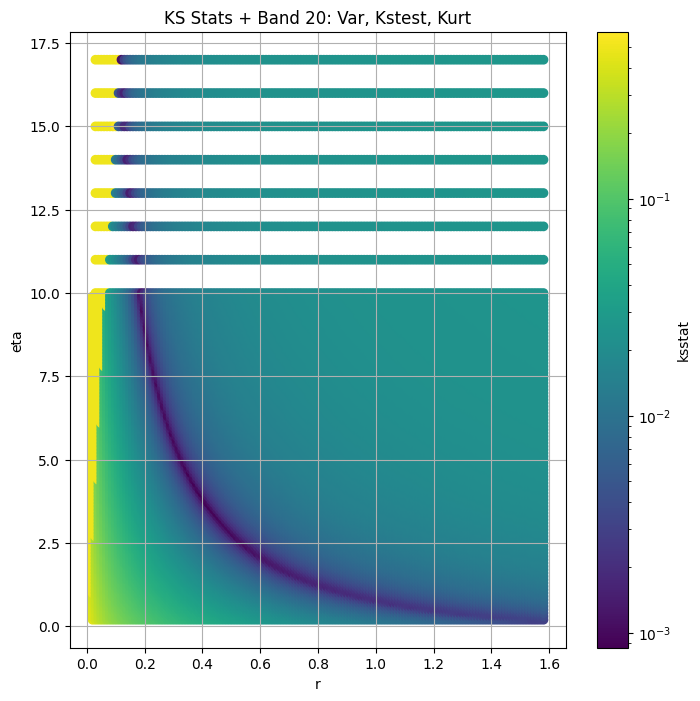

####
Band  23


100%|██████████| 55966/55966 [05:13<00:00, 178.36it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 610560.0


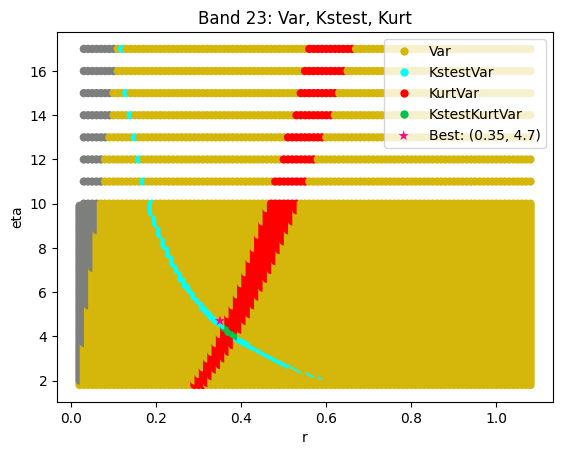

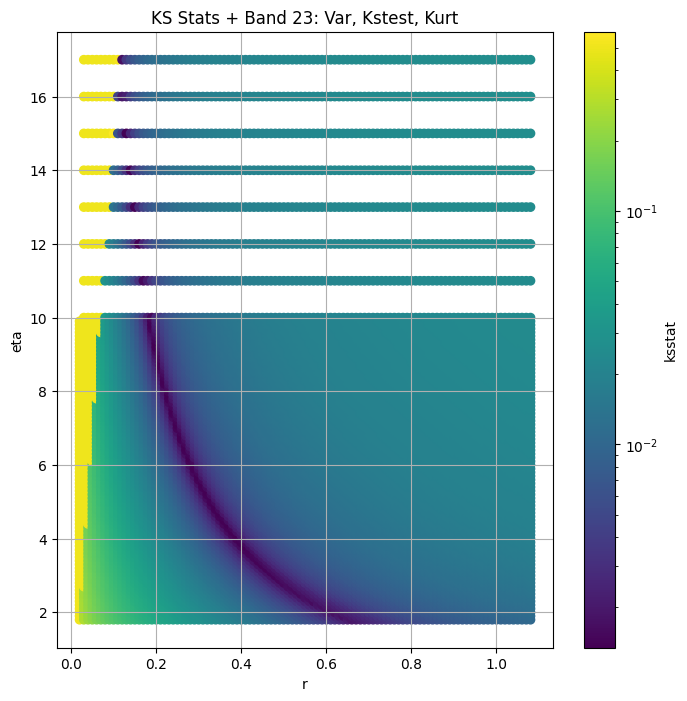

####
Band  26


100%|██████████| 55966/55966 [05:08<00:00, 181.43it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 973080.0


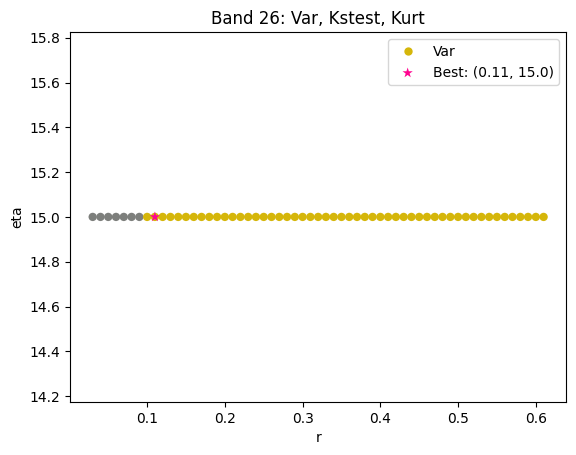

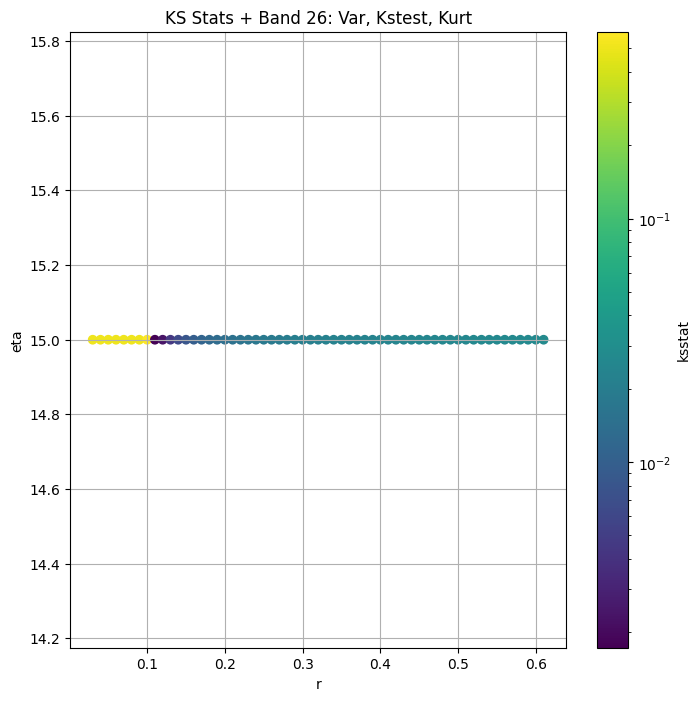

####
Band  29


100%|██████████| 55966/55966 [05:15<00:00, 177.47it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1376940.0


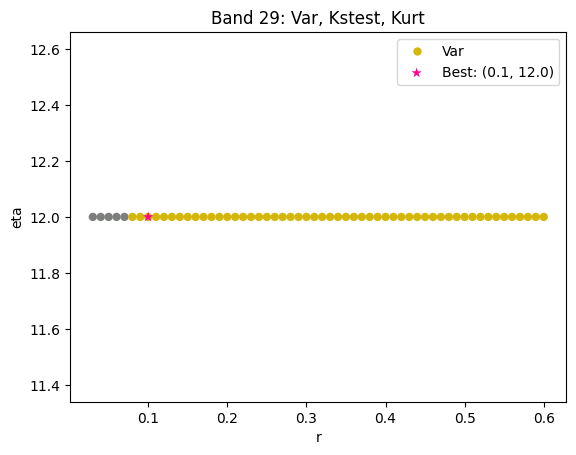

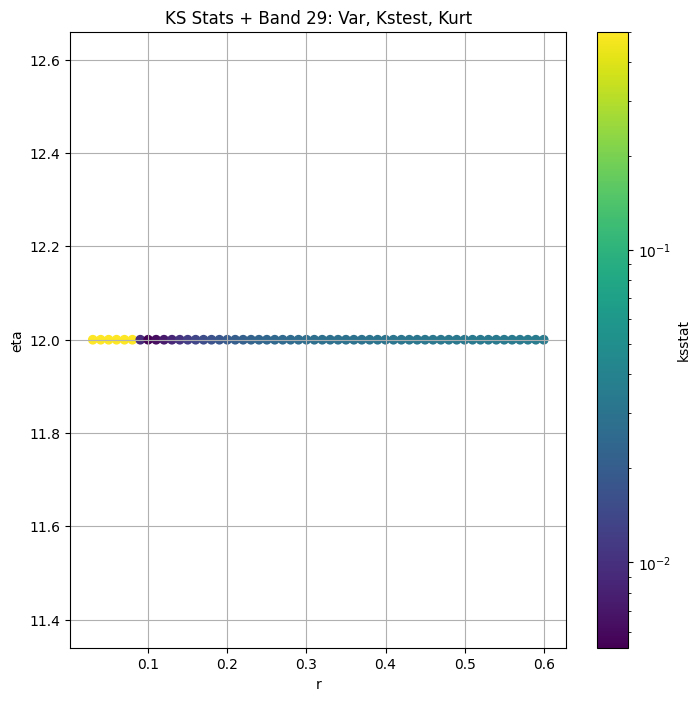

####
Band  32


100%|██████████| 55966/55966 [05:21<00:00, 174.04it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 419760.0


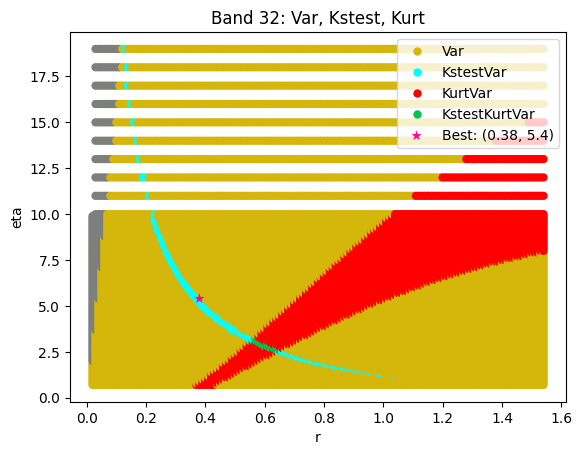

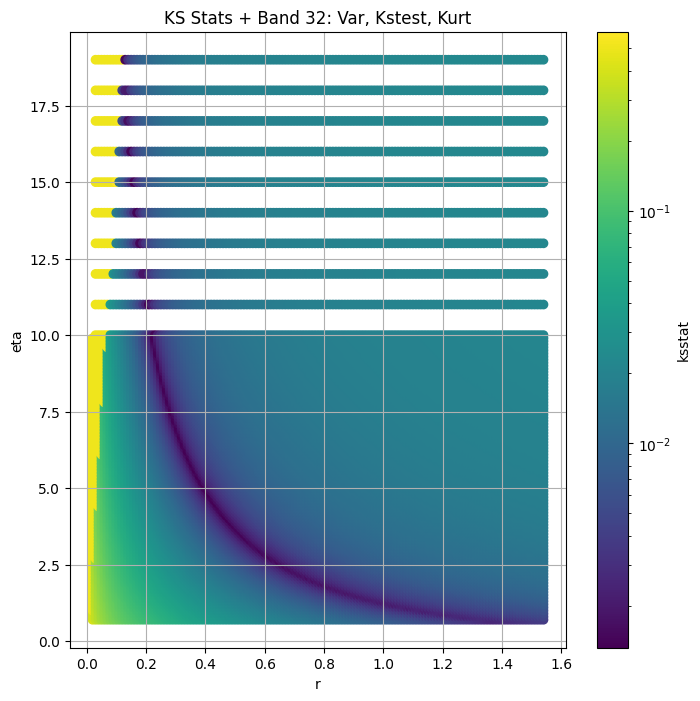

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                     
2     164622.750000  156708.31000  172875.03000   1.573100    1.155113   
5      89105.410000   84883.04000   93516.57000   1.501235    1.010971   
8      49459.945000   47133.05000   51857.87000   1.475068    1.028498   
11     28516.895000   27105.72500   29987.74800   1.817942    1.125604   
14     15809.663000   15056.35000   16603.17200   1.633317    1.063960   
17      8928.170000    8495.97900    9380.36100   1.674846    1.077402   
20      4547.406700    4326.05800    4780.43460   1.779029    1.113188   
23      2160.474900    2054.57640    2273.18460   1.860174    1.162968   
26       900.715800     848.15436     965.53920   4.115283    1.578929   
29       316.848000     290.46594     357.91980  14.169542    3.107159   
32        36.040783      34.37498      37.77347   1.344013    0.882763   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2       2.074450        31800.0       0.52          2.6   2.790941e+03   
5       2.142560        41340.0       2.00          0.4   1.000000e+05   
8       2.087626        66780.0       0.74          2.0   5.777599e+03   
11      2.967208       104940.0       0.24          8.6   4.185921e-03   
14      2.714023       162180.0       0.31          6.3   4.174376e-01   
17      3.061004       257580.0       0.28          6.5   4.825985e-02   
20      4.050655       381600.0       0.40          4.0   5.694754e+00   
23      3.403249       610560.0       0.35          4.7   5.076689e-01   
26     15.710218       973080.0       0.11         15.0   1.167984e-17   
29     60.432312      1376940.0       0.10         12.0   1.137705e-19   
32      2.353983       419760.0       0.38          5.4   1.563226e-02   

      kstest_stat_initial  kstest_stat_cutoff_0.05  
band                                                
2                0.003621                 0.007611  
5                0.003014                 0.006675  
8                0.002981                 0.005253  
11               0.002223                 0.004191  
14               0.002367                 0.003371  
17               0.000951                 0.002675  
20               0.000852                 0.002198  
23               0.001344                 0.001738  
26               0.001729                 0.001377  
29               0.005328                 0.001157  
32               0.001322                 0.002096

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

  0%|          | 0/369 [00:00<?, ?it/s]

100%|██████████| 369/369 [00:00<00:00, 407.31it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 402.86it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 259.76it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 175.38it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 174.52it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 178.28it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 156.34it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 170.79it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 164.08it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 169.16it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 170.62it/s]

Finding Minimum after computing 369 CDFs


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                     
2     164622.750000  156708.31000  172875.03000   1.573100    1.155113   
5      89105.410000   84883.04000   93516.57000   1.501235    1.010971   
8      49459.945000   47133.05000   51857.87000   1.475068    1.028498   
11     28516.895000   27105.72500   29987.74800   1.817942    1.125604   
14     15809.663000   15056.35000   16603.17200   1.633317    1.063960   
17      8928.170000    8495.97900    9380.36100   1.674846    1.077402   
20      4547.406700    4326.05800    4780.43460   1.779029    1.113188   
23      2160.474900    2054.57640    2273.18460   1.860174    1.162968   
26       900.715800     848.15436     965.53920   4.115283    1.578929   
29       316.848000     290.46594     357.91980  14.169542    3.107159   
32        36.040783      34.37498      37.77347   1.344013    0.882763   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2       2.074450        31800.0       0.52          2.6   2.790941e+03   
5       2.142560        41340.0       2.00          0.4   1.000000e+05   
8       2.087626        66780.0       0.74          2.0   5.777599e+03   
11      2.967208       104940.0       0.24          8.6   4.185921e-03   
14      2.714023       162180.0       0.31          6.3   4.174376e-01   
17      3.061004       257580.0       0.28          6.5   4.825985e-02   
20      4.050655       381600.0       0.40          4.0   5.694754e+00   
23      3.403249       610560.0       0.35          4.7   5.076689e-01   
26     15.710218       973080.0       0.11         15.0   1.167984e-17   
29     60.432312      1376940.0       0.10         12.0   1.137705e-19   
32      2.353983       419760.0       0.38          5.4   1.563226e-02   

      kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
band                                                              
2                0.003621                 0.007611         0.89   
5                0.003014                 0.006675         1.67   
8                0.002981                 0.005253         6.00   
11               0.002223                 0.004191         6.00   
14               0.002367                 0.003371         6.00   
17               0.000951                 0.002675         6.00   
20               0.000852                 0.002198         6.00   
23               0.001344                 0.001738         6.00   
26               0.001729                 0.001377         5.90   
29               0.005328                 0.001157         5.90   
32               0.001322                 0.002096         5.80   

      best_scale_eta0  kstest_stat_eta0  
band                                     
2           19.329002          0.010651  
5           43.522322          0.015648  
8           61.417775          0.026320  
11          61.417775          0.086840  
14          61.417775          0.147266  
17          61.417775          0.200995  
20          61.417775          0.257715  
23          61.417775          0.311443  
26          61.376983          0.363134  
29          61.376983          0.409505  
32          61.332968          0.461330

## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.512, 2.57), 50 of 441
(0.514, 2.65), 100 of 441
(0.517, 2.52), 150 of 441
(0.519, 2.6), 200 of 441
(0.521, 2.68), 250 of 441
(0.524, 2.55), 300 of 441
(0.526, 2.63), 350 of 441
(0.529, 2.5), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 552.57it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 2 best parameters: ((0.525, 2.56), 0.0036070738512861134)


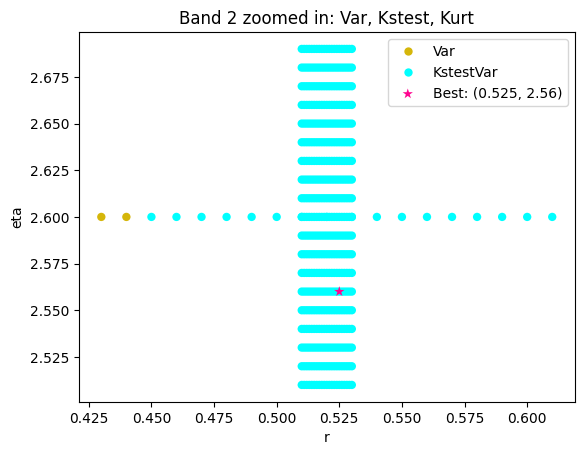

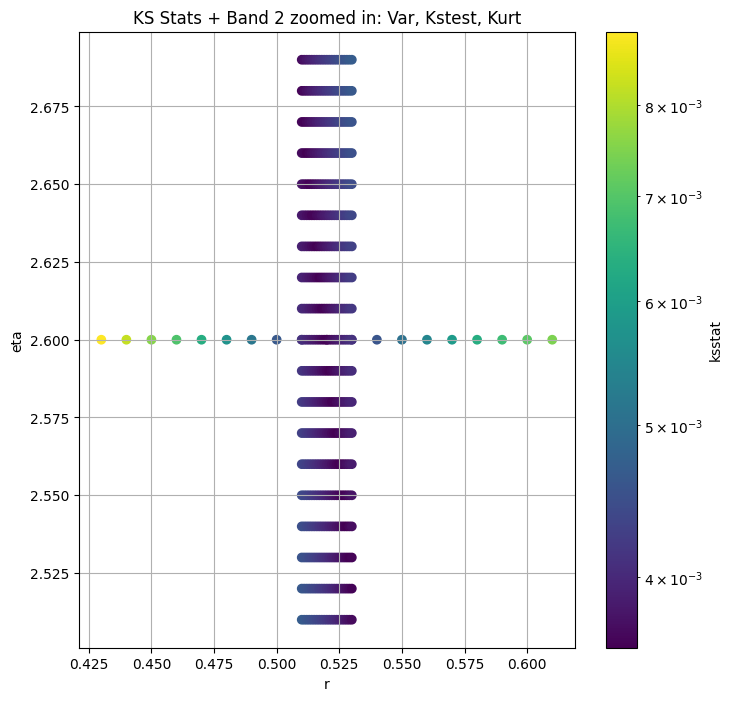

Band 5
(1.92, 0.39), 50 of 420
(1.94, 0.49), 100 of 420
(1.97, 0.39), 150 of 420
(1.99, 0.49), 200 of 420
(2.02, 0.39), 250 of 420
(2.04, 0.49), 300 of 420
(2.07, 0.39), 350 of 420
(2.09, 0.49), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 436.36it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 5 best parameters: ((1.97, 0.38), 0.002966921802275979)


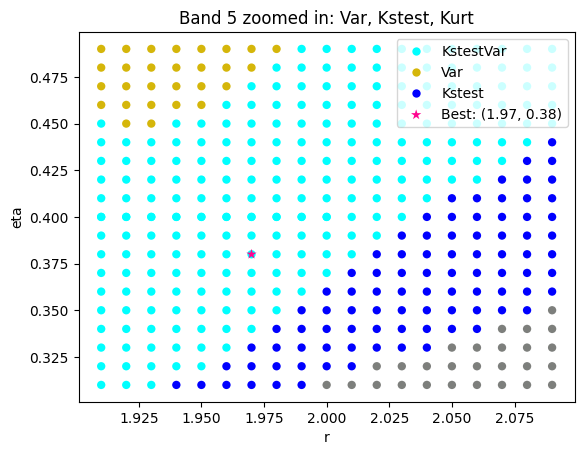

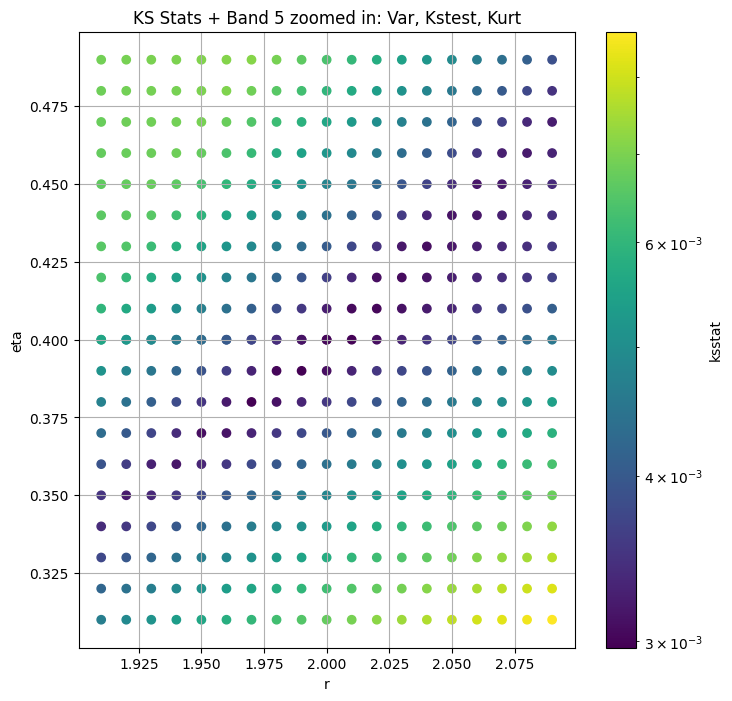

Band 8
(0.732, 1.97), 50 of 441
(0.734, 2.05), 100 of 441
(0.737, 1.92), 150 of 441
(0.739, 2.0), 200 of 441
(0.741, 2.08), 250 of 441
(0.744, 1.95), 300 of 441
(0.746, 2.03), 350 of 441
(0.749, 1.9), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 273.50it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 8 best parameters: ((0.731, 2.04), 0.0029656716033023)


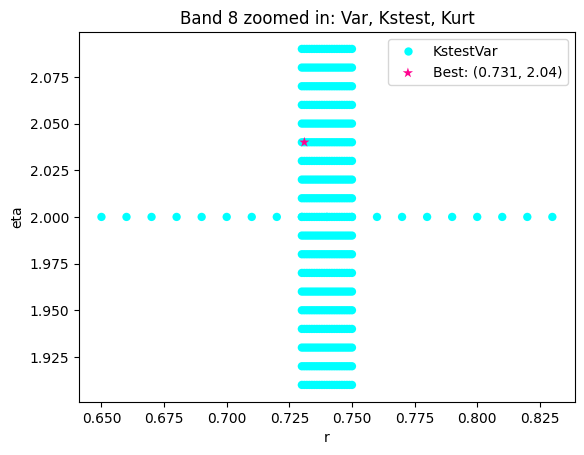

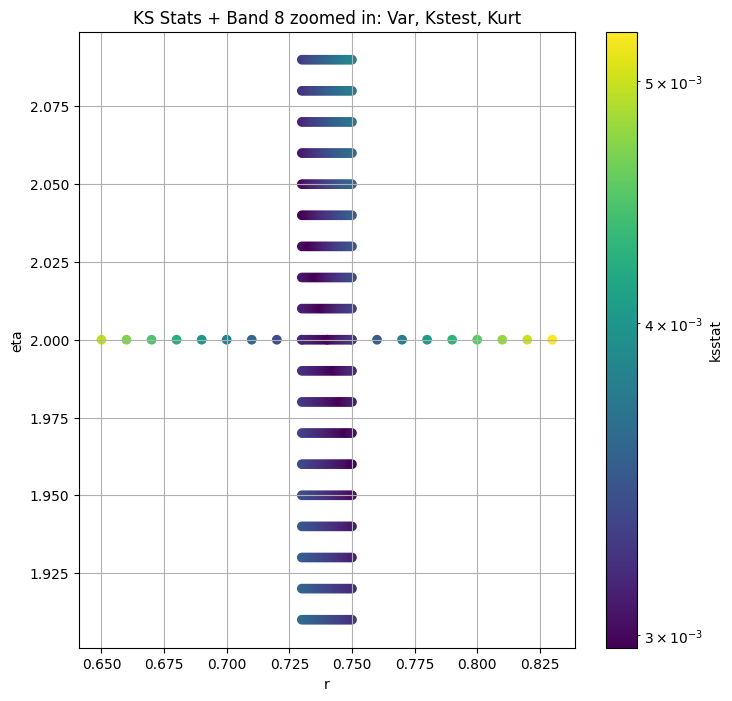

Band 11
(0.232, 8.59), 50 of 420
(0.234, 8.69), 100 of 420
(0.237, 8.59), 150 of 420
(0.239, 8.69), 200 of 420
(0.242, 8.59), 250 of 420
(0.244, 8.69), 300 of 420
(0.247, 8.59), 350 of 420
(0.249, 8.69), 400 of 420


100%|██████████| 420/420 [00:02<00:00, 181.21it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 11 best parameters: ((0.24, 8.61), 0.0022200042447244606)


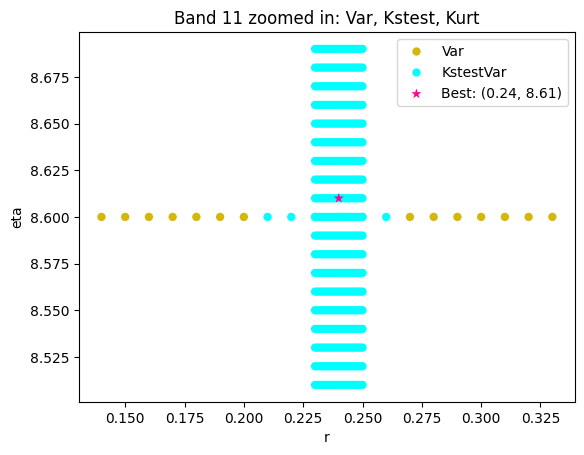

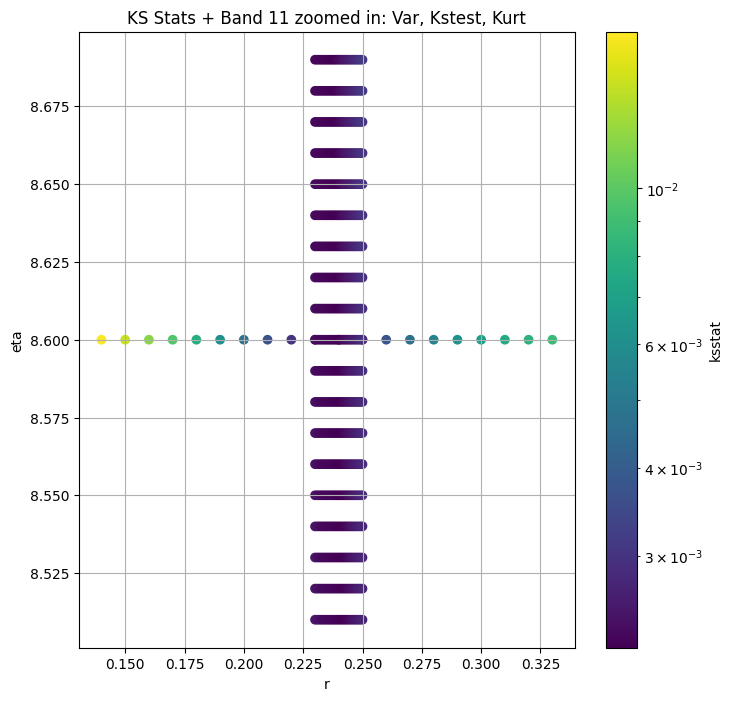

Band 14
(0.302, 6.29), 50 of 420
(0.304, 6.39), 100 of 420
(0.307, 6.29), 150 of 420
(0.309, 6.39), 200 of 420
(0.312, 6.29), 250 of 420
(0.314, 6.39), 300 of 420
(0.317, 6.29), 350 of 420
(0.319, 6.39), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 238.90it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.314, 6.2), 0.002365160291257551)


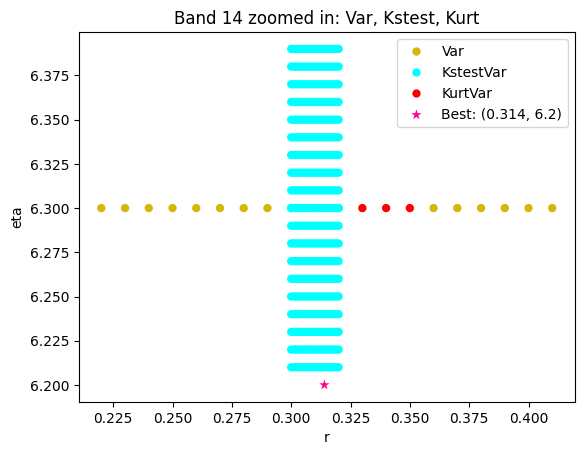

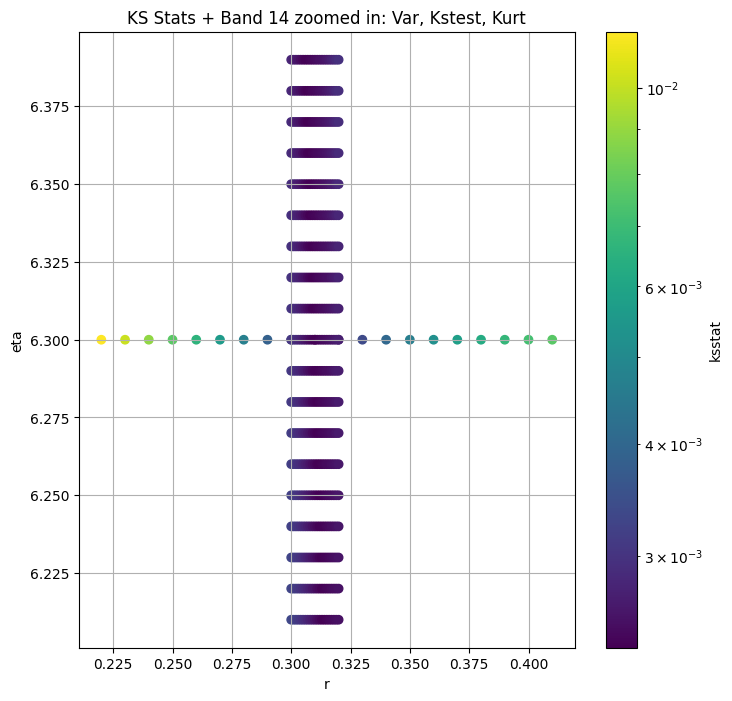

Band 17
(0.272, 6.49), 50 of 420
(0.274, 6.59), 100 of 420
(0.277, 6.49), 150 of 420
(0.279, 6.59), 200 of 420
(0.282, 6.49), 250 of 420
(0.284, 6.59), 300 of 420
(0.287, 6.49), 350 of 420
(0.289, 6.59), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 263.13it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 17 best parameters: ((0.28, 6.51), 0.0009224692539512858)


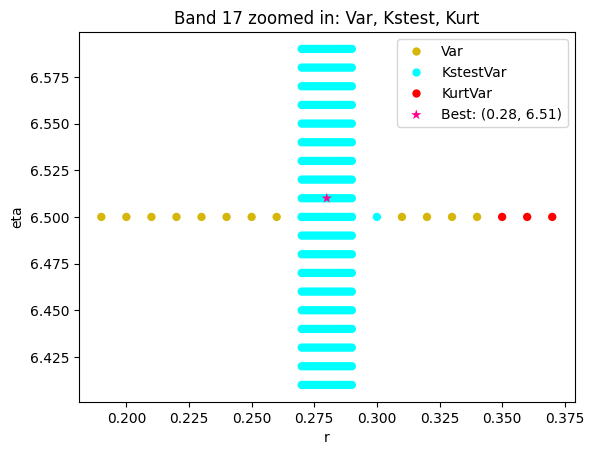

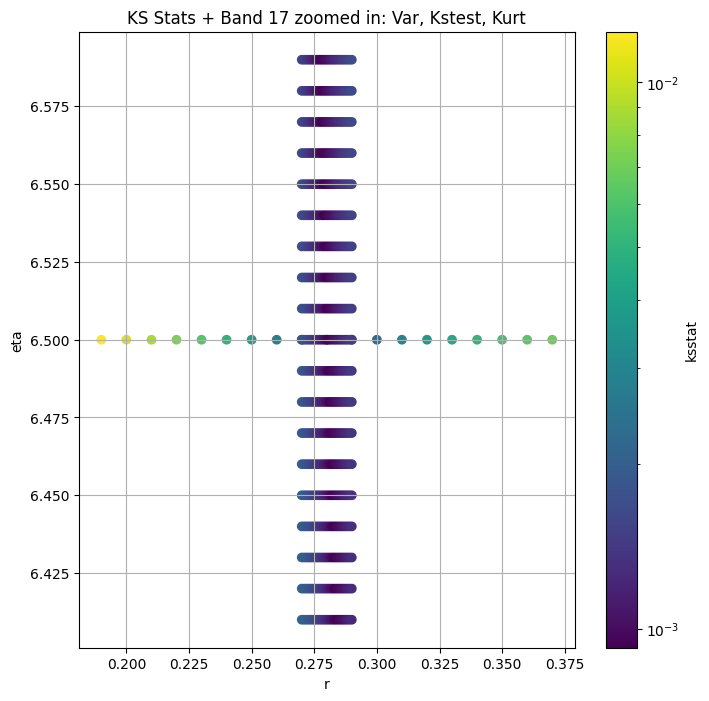

Band 20
(0.392, 3.99), 50 of 420
(0.394, 4.09), 100 of 420
(0.397, 3.99), 150 of 420
(0.399, 4.09), 200 of 420
(0.402, 3.99), 250 of 420
(0.404, 4.09), 300 of 420
(0.407, 3.99), 350 of 420
(0.409, 4.09), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 264.76it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 20 best parameters: ((0.393, 4.09), 0.0008463339761682689)


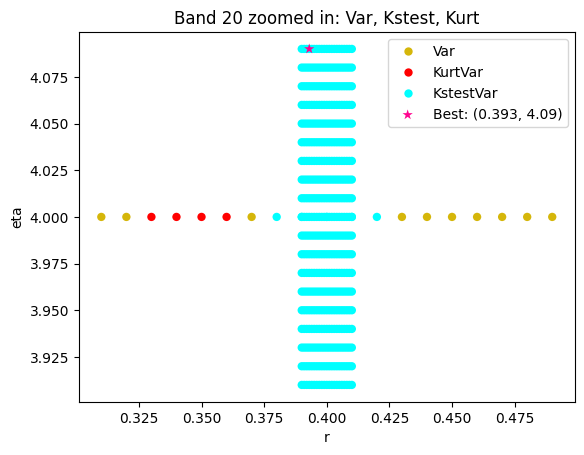

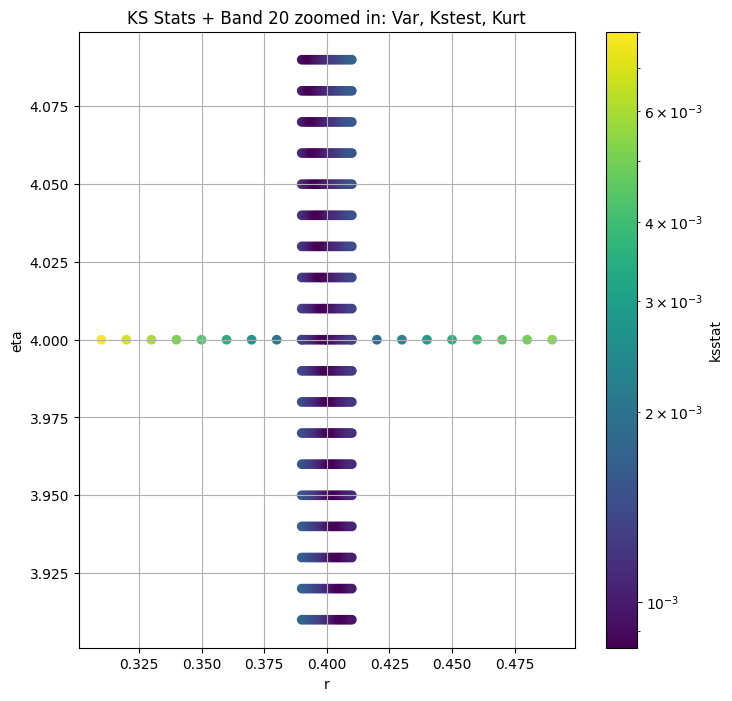

Band 23
(0.342, 4.69), 50 of 420
(0.344, 4.79), 100 of 420
(0.347, 4.69), 150 of 420
(0.349, 4.79), 200 of 420
(0.352, 4.69), 250 of 420
(0.354, 4.79), 300 of 420
(0.357, 4.69), 350 of 420
(0.359, 4.79), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 276.48it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 23 best parameters: ((0.346, 4.77), 0.0013439208463289498)


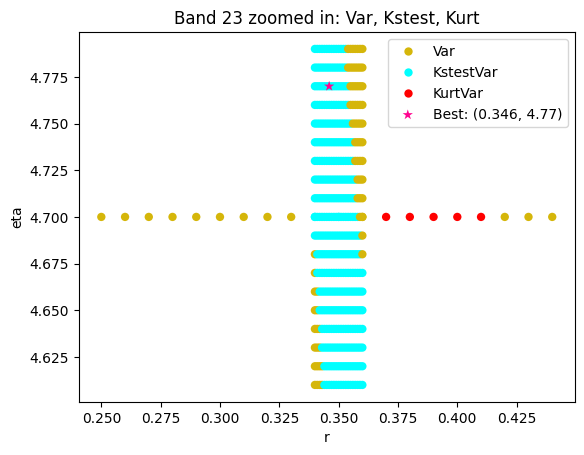

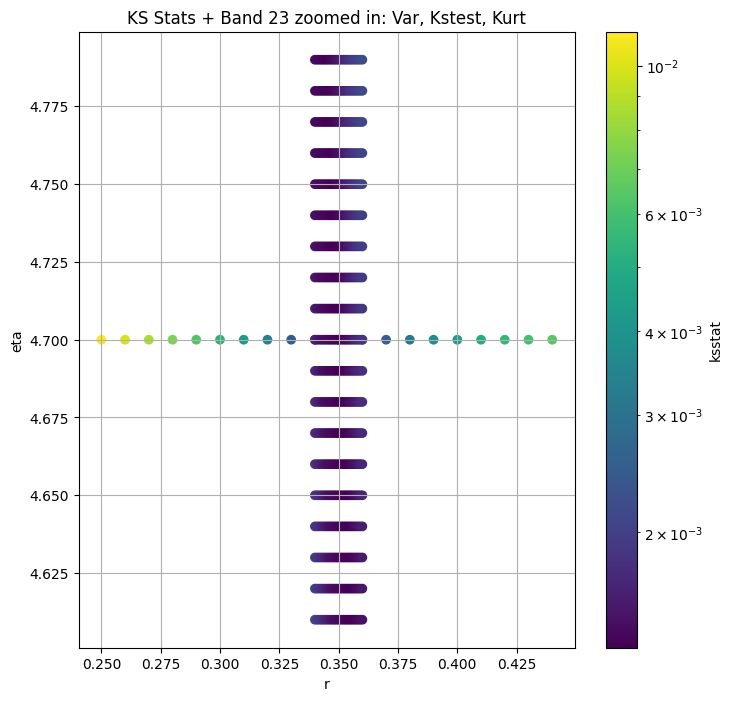

Band 26


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:76: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)


(0.102, 14.9), 50 of 400
(0.104, 15.9), 100 of 400
(0.107, 14.9), 150 of 400
(0.109, 15.9), 200 of 400
(0.112, 14.9), 250 of 400
(0.114, 15.9), 300 of 400
(0.117, 14.9), 350 of 400
(0.119, 15.9), 400 of 400


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

Finding Minimum after computing 400 CDFs
Iter 1 band 26 best parameters: ((0.107, 15.5), 0.0017005384174369476)


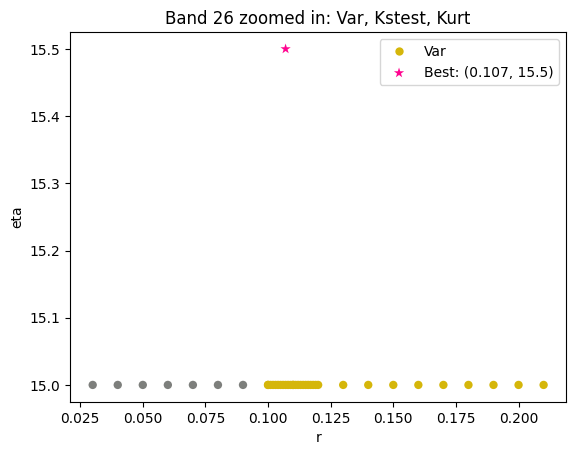

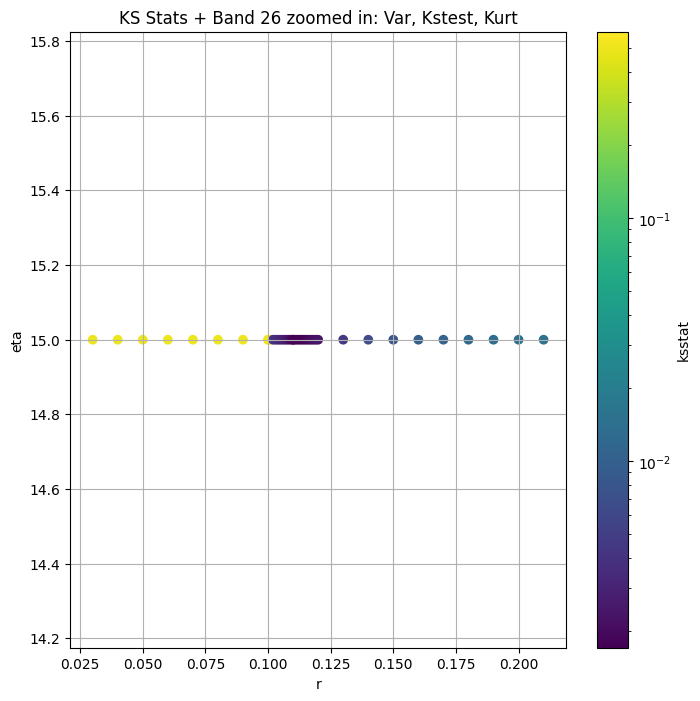

Band 29
(0.092, 11.9), 50 of 400
(0.094, 12.9), 100 of 400
(0.097, 11.9), 150 of 400
(0.099, 12.9), 200 of 400
(0.102, 11.9), 250 of 400
(0.104, 12.9), 300 of 400
(0.107, 11.9), 350 of 400
(0.109, 12.9), 400 of 400


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 400/400 [00:02<00:00, 182.47it/s]
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assign

Finding Minimum after computing 400 CDFs
Iter 1 band 29 best parameters: ((0.094, 12.7), 0.0052279211552557145)


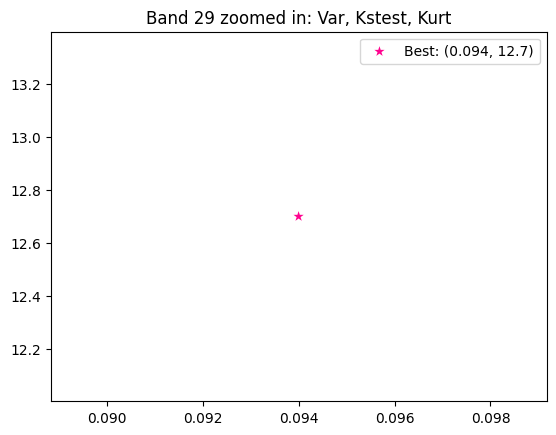

Band 32
(0.372, 5.39), 50 of 420
(0.374, 5.49), 100 of 420
(0.377, 5.39), 150 of 420
(0.379, 5.49), 200 of 420
(0.382, 5.39), 250 of 420
(0.384, 5.49), 300 of 420
(0.387, 5.39), 350 of 420
(0.389, 5.49), 400 of 420


100%|██████████| 420/420 [00:02<00:00, 178.36it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 32 best parameters: ((0.385, 5.31), 0.0013192208510794945)


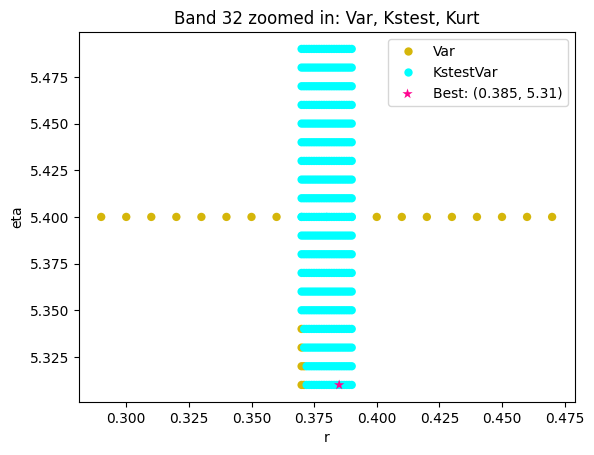

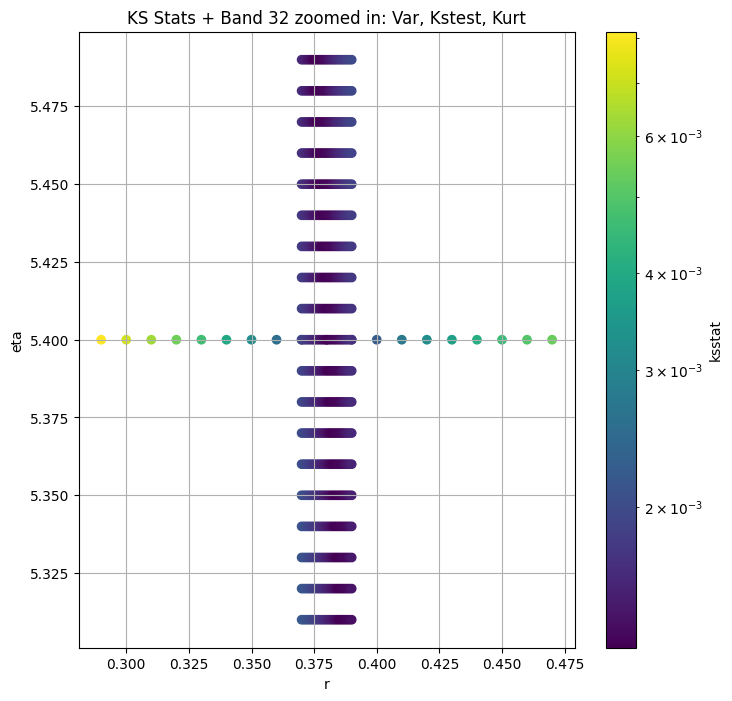

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                     
2     164622.750000  156708.31000  172875.03000   1.573100    1.155113   
5      89105.410000   84883.04000   93516.57000   1.501235    1.010971   
8      49459.945000   47133.05000   51857.87000   1.475068    1.028498   
11     28516.895000   27105.72500   29987.74800   1.817942    1.125604   
14     15809.663000   15056.35000   16603.17200   1.633317    1.063960   
17      8928.170000    8495.97900    9380.36100   1.674846    1.077402   
20      4547.406700    4326.05800    4780.43460   1.779029    1.113188   
23      2160.474900    2054.57640    2273.18460   1.860174    1.162968   
26       900.715800     848.15436     965.53920   4.115283    1.578929   
29       316.848000     290.46594     357.91980  14.169542    3.107159   
32        36.040783      34.37498      37.77347   1.344013    0.882763   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       2.074450        31800.0       0.52          2.6   2.790941e+03  ...   
5       2.142560        41340.0       2.00          0.4   1.000000e+05  ...   
8       2.087626        66780.0       0.74          2.0   5.777599e+03  ...   
11      2.967208       104940.0       0.24          8.6   4.185921e-03  ...   
14      2.714023       162180.0       0.31          6.3   4.174376e-01  ...   
17      3.061004       257580.0       0.28          6.5   4.825985e-02  ...   
20      4.050655       381600.0       0.40          4.0   5.694754e+00  ...   
23      3.403249       610560.0       0.35          4.7   5.076689e-01  ...   
26     15.710218       973080.0       0.11         15.0   1.167984e-17  ...   
29     60.432312      1376940.0       0.10         12.0   1.137705e-19  ...   
32      2.353983       419760.0       0.38          5.4   1.563226e-02  ...   

      best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
band                                                                      
2           19.329002          0.010651   0.525      2.56  3.010844e+03   
5           43.522322          0.015648   1.970      0.38  1.000000e+05   
8           61.417775          0.026320   0.731      2.04  5.442039e+03   
11          61.417775          0.086840   0.240      8.61  4.169308e-03   
14          61.417775          0.147266   0.314      6.20  5.177194e-01   
17          61.417775          0.200995   0.280      6.51  4.805402e-02   
20          61.417775          0.257715   0.393      4.09  4.640544e+00   
23          61.417775          0.311443   0.346      4.77  4.319216e-01   
26          61.376983          0.363134   0.107     15.50  1.901984e-18   
29          61.376983          0.409505   0.094     12.70  1.493118e-21   
32          61.332968          0.461330   0.385      5.31  1.849364e-02   

      kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
band                                                                        
2             0.003607    0.525       2.56           0.003607       135831  
5             0.002967    1.970       0.38           0.002967       209283  
8             0.002966    0.731       2.04           0.002966       213934  
11            0.002220    0.240       8.61           0.002220       378207  
14            0.002365    0.314       6.20           0.002365       346372  
17            0.000922    0.280       6.51           0.000922      2200495  
20            0.000846    0.393       4.09           0.000846      2610936  
23            0.001344    0.346       4.77           0.001344      1030320  
26            0.001701    0.107      15.50           0.001701       615775  
29            0.005228    0.094      12.70           0.005228        64543  
32            0.001319    0.385       5.31           0.001319      1062517  

[11 rows x 23 columns]

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

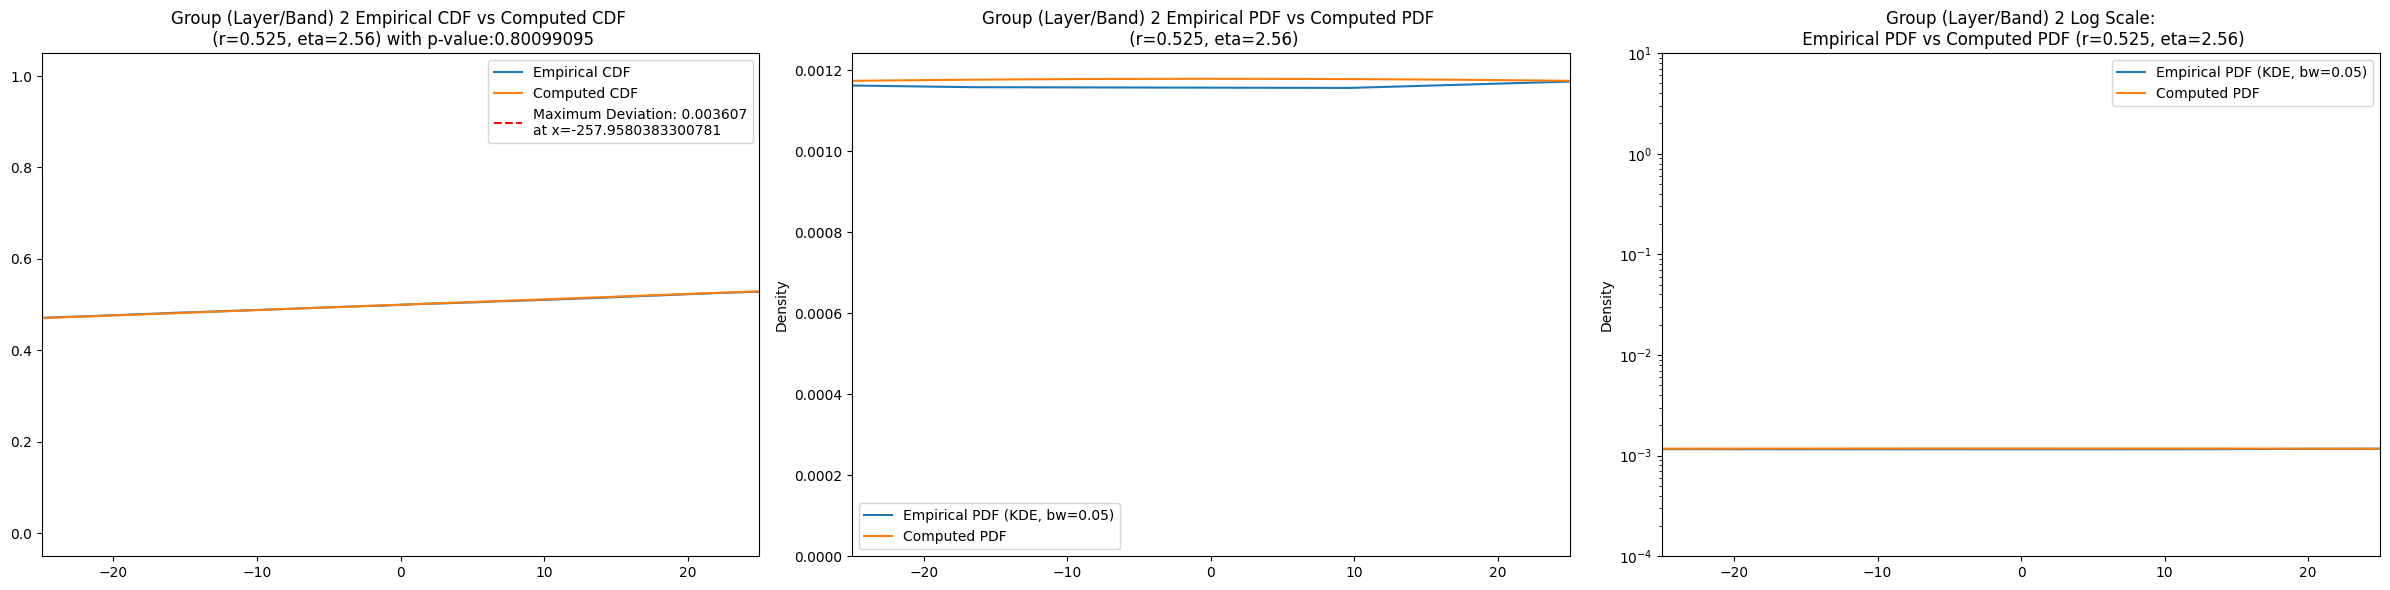

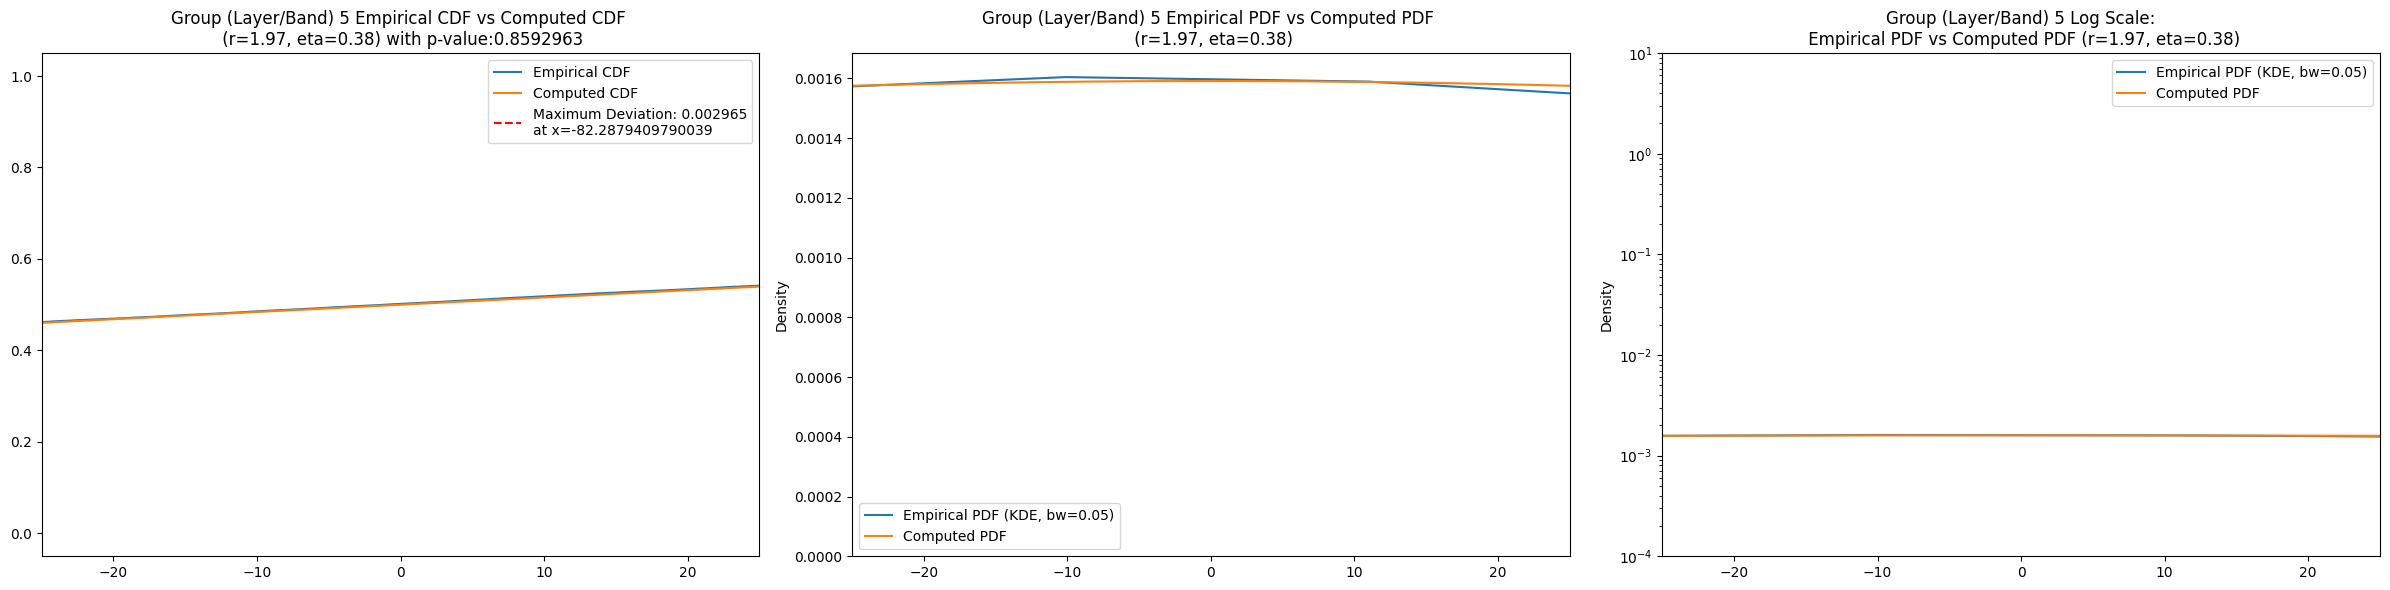

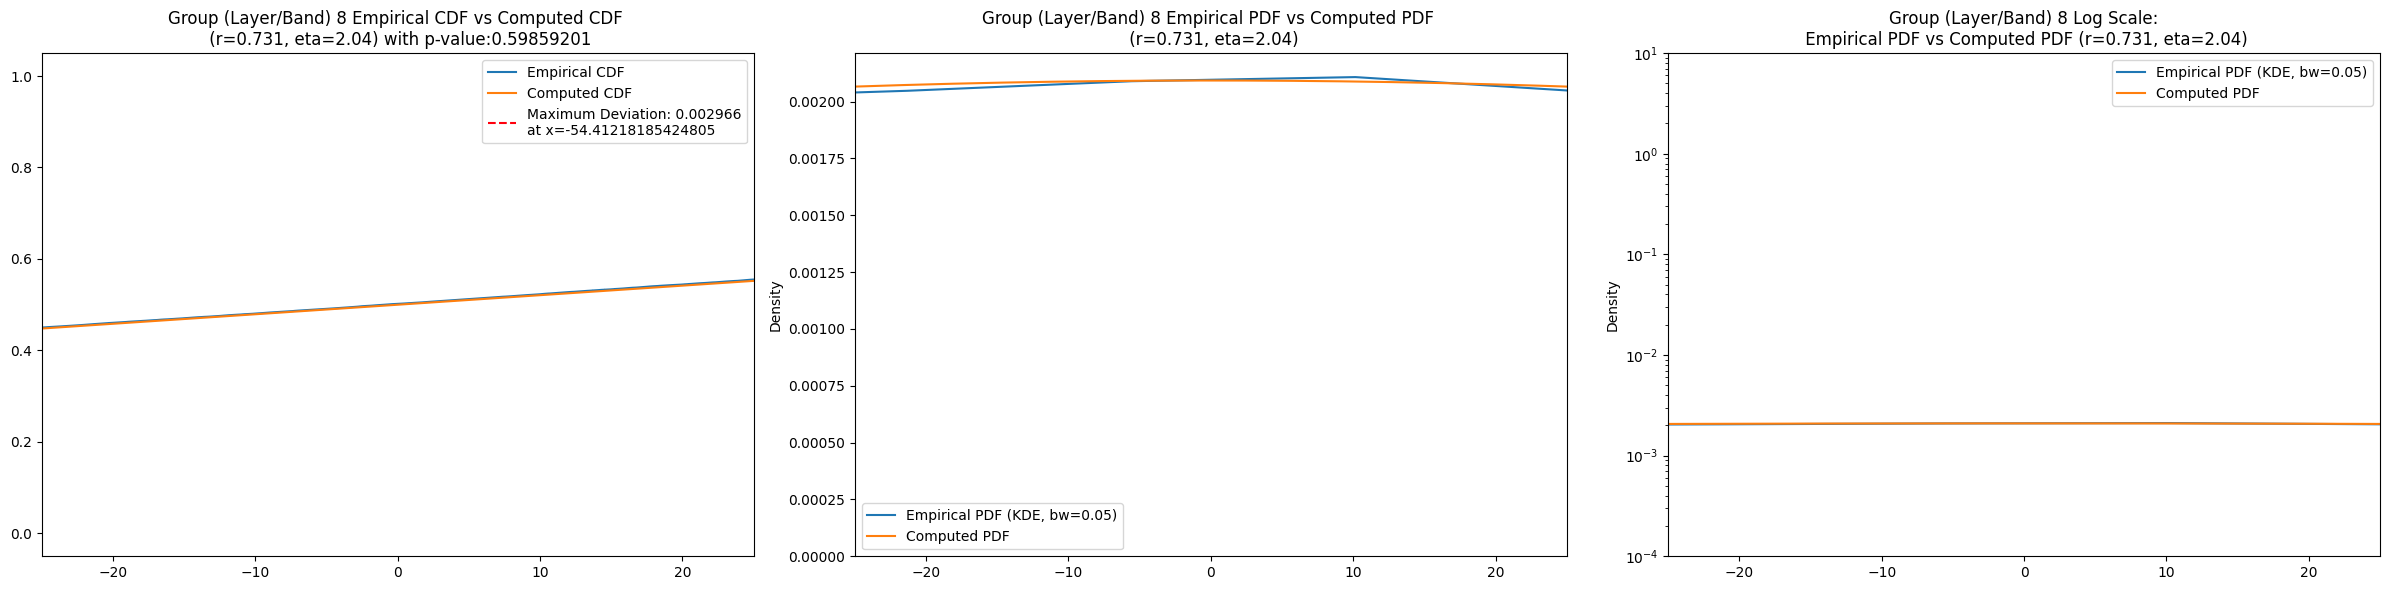

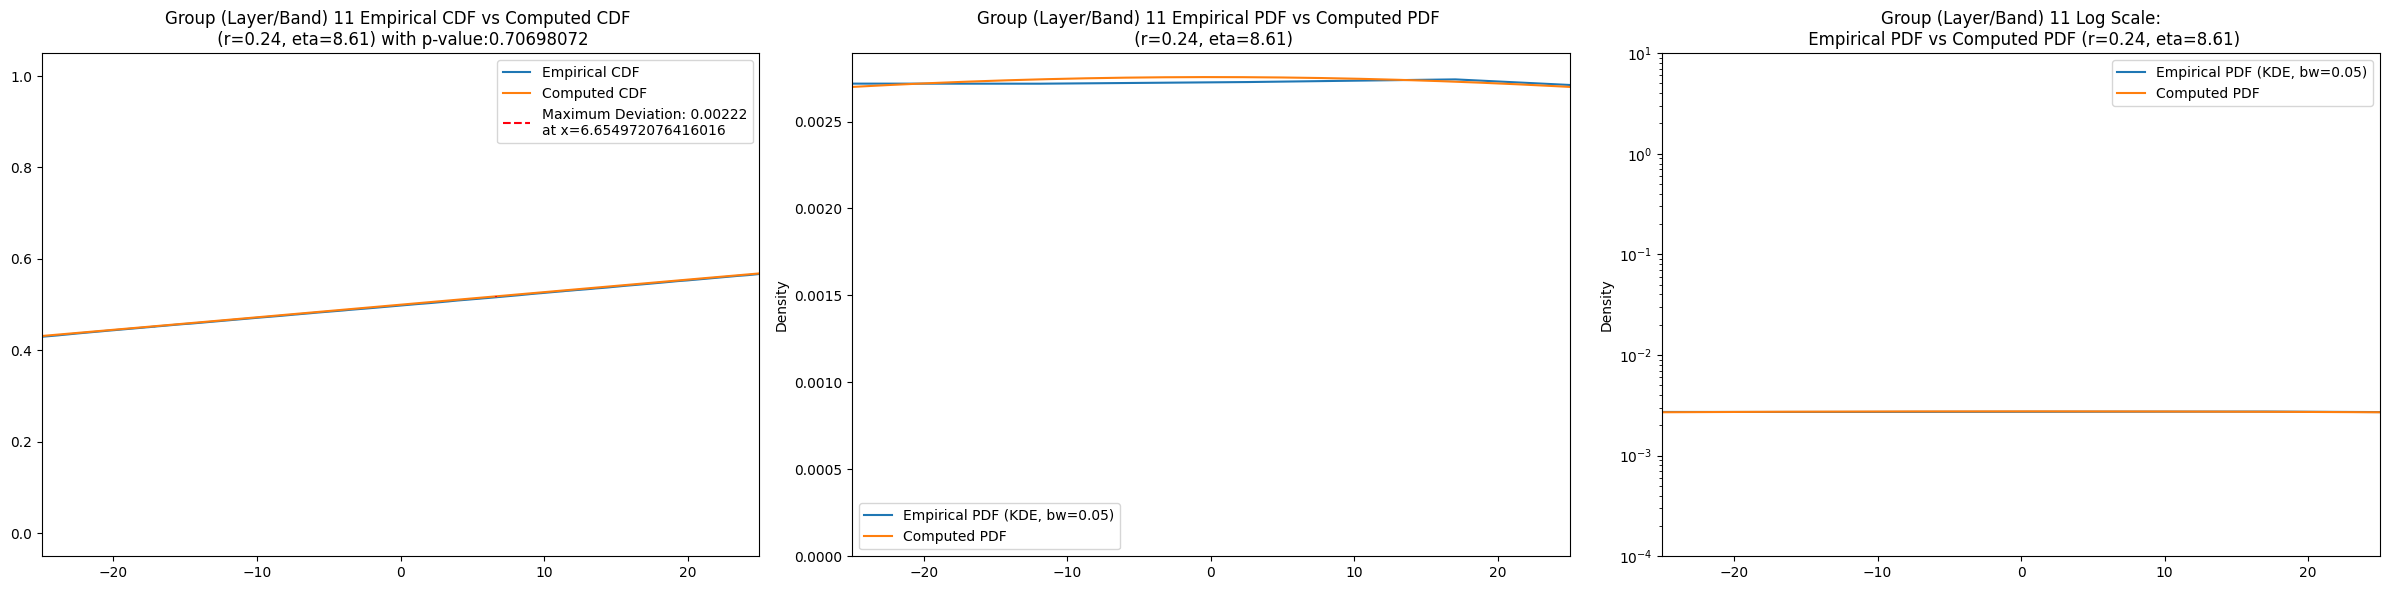

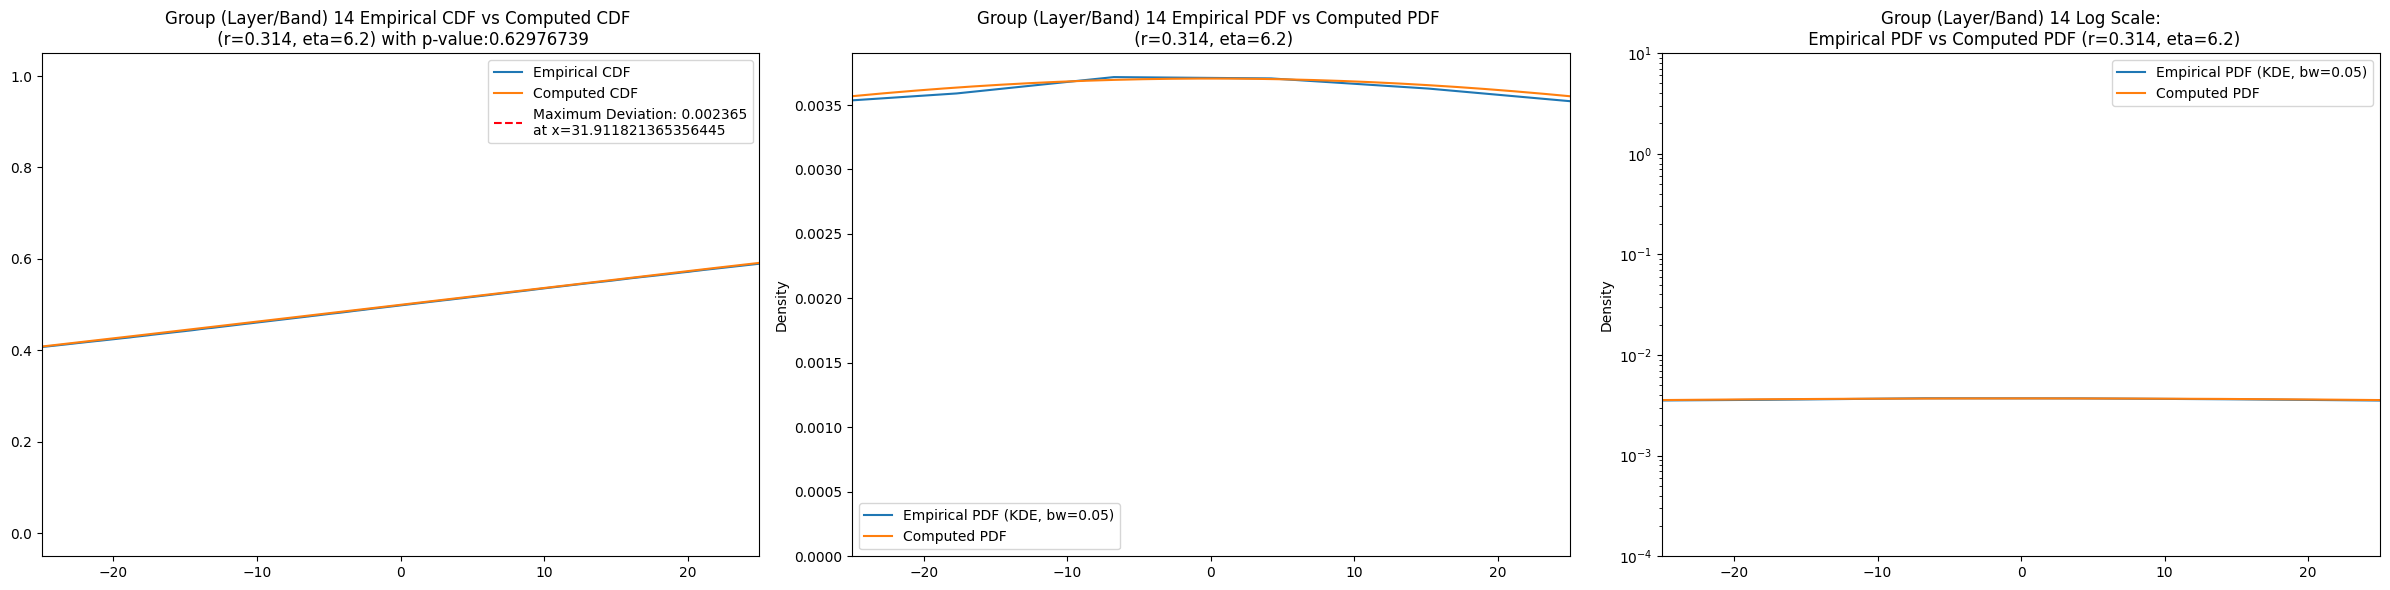

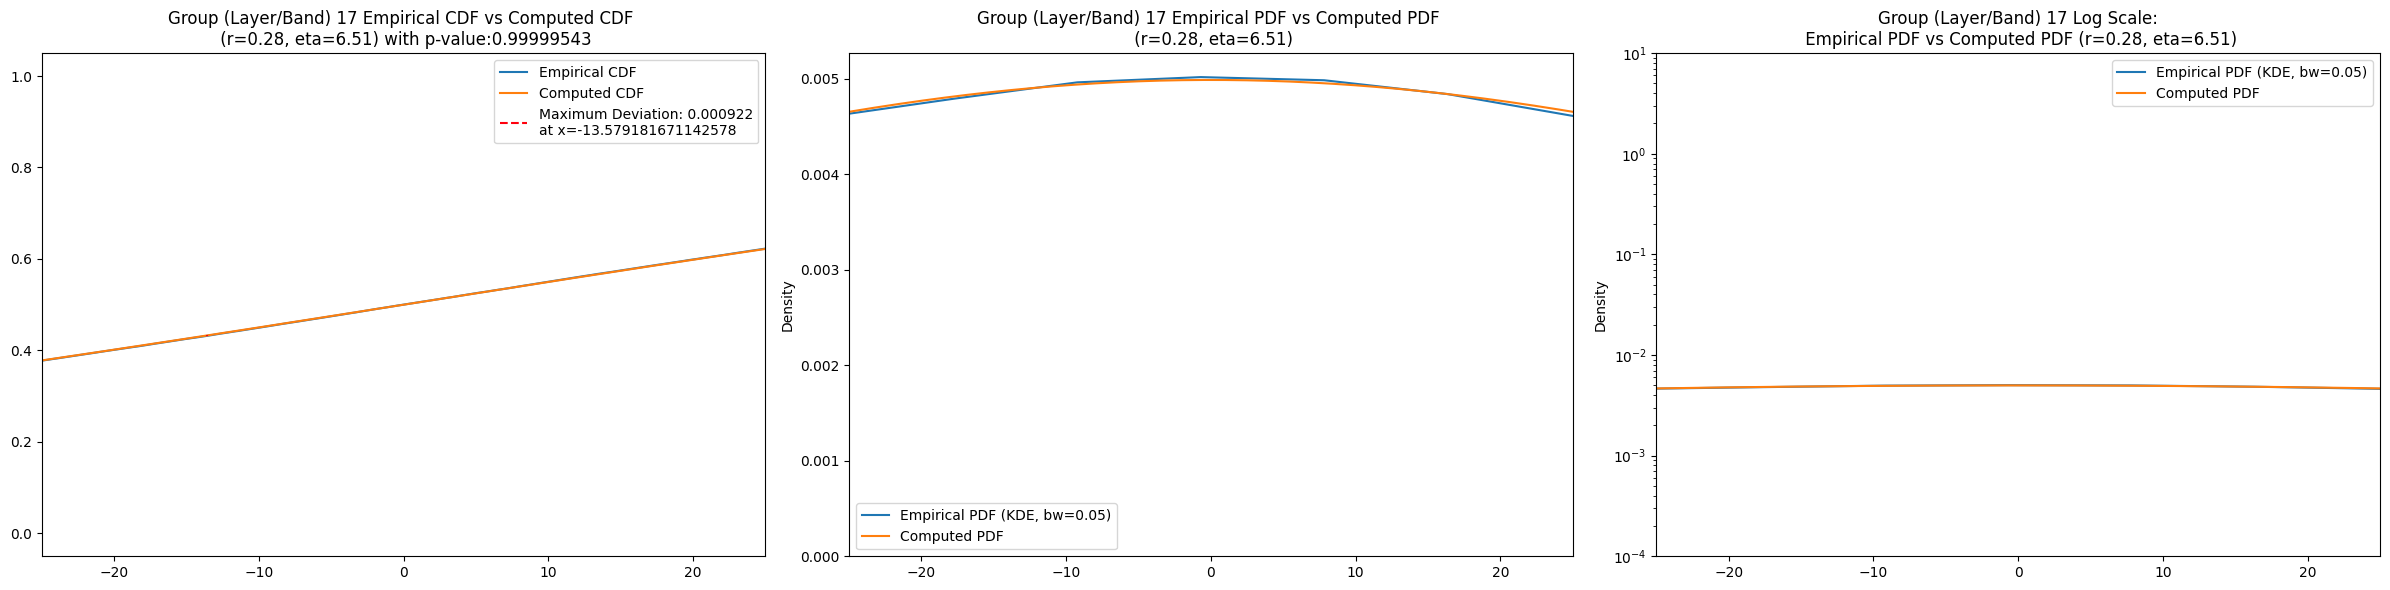

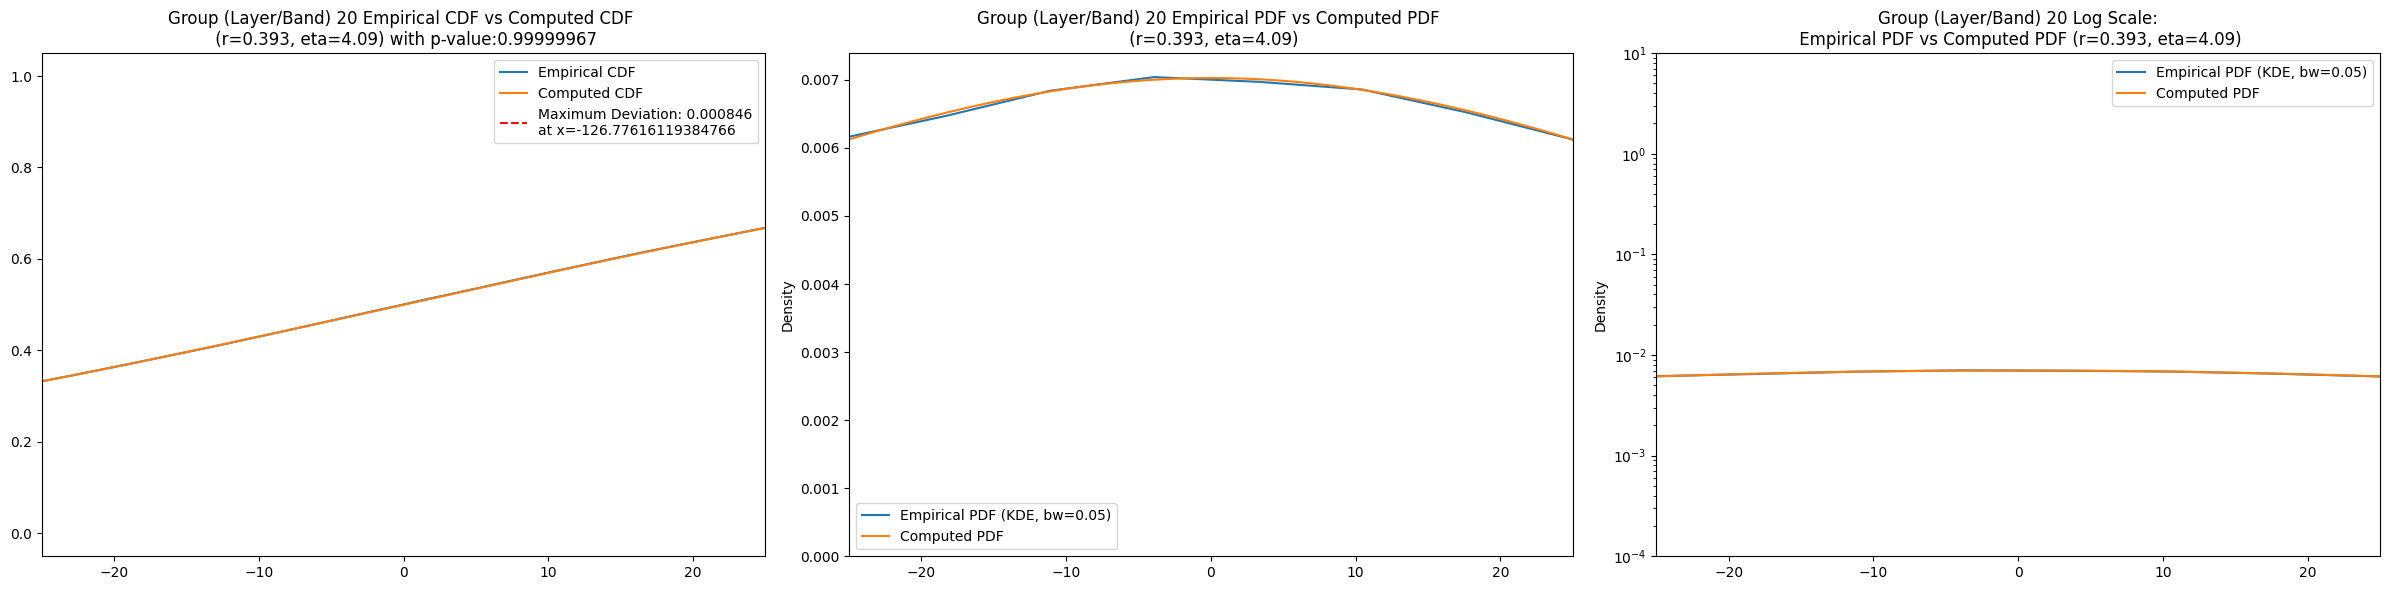

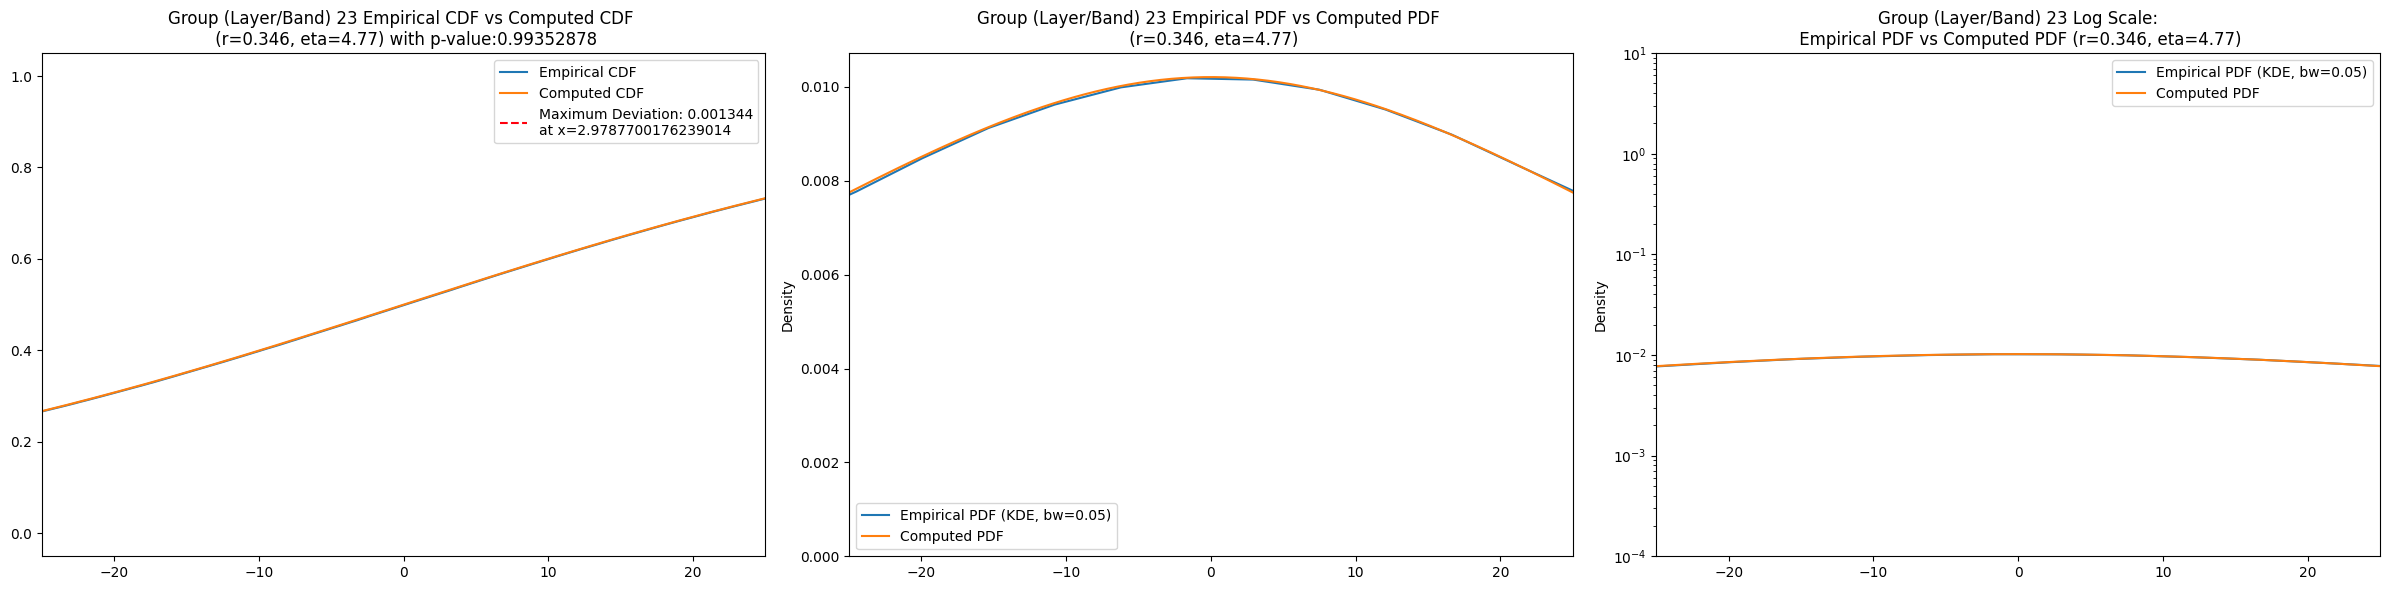

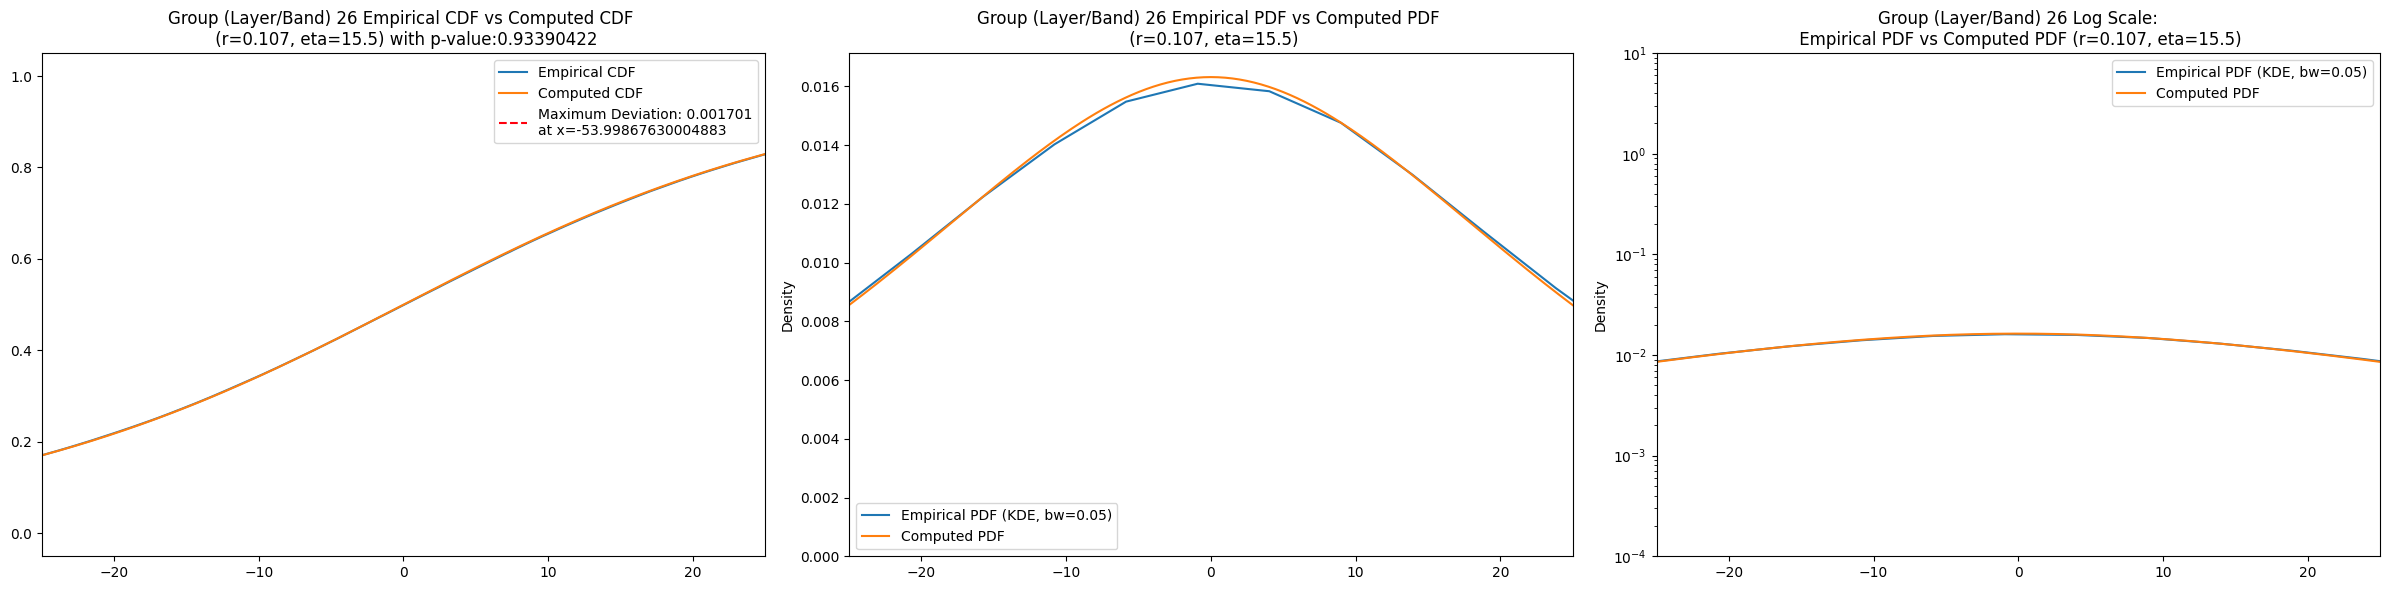

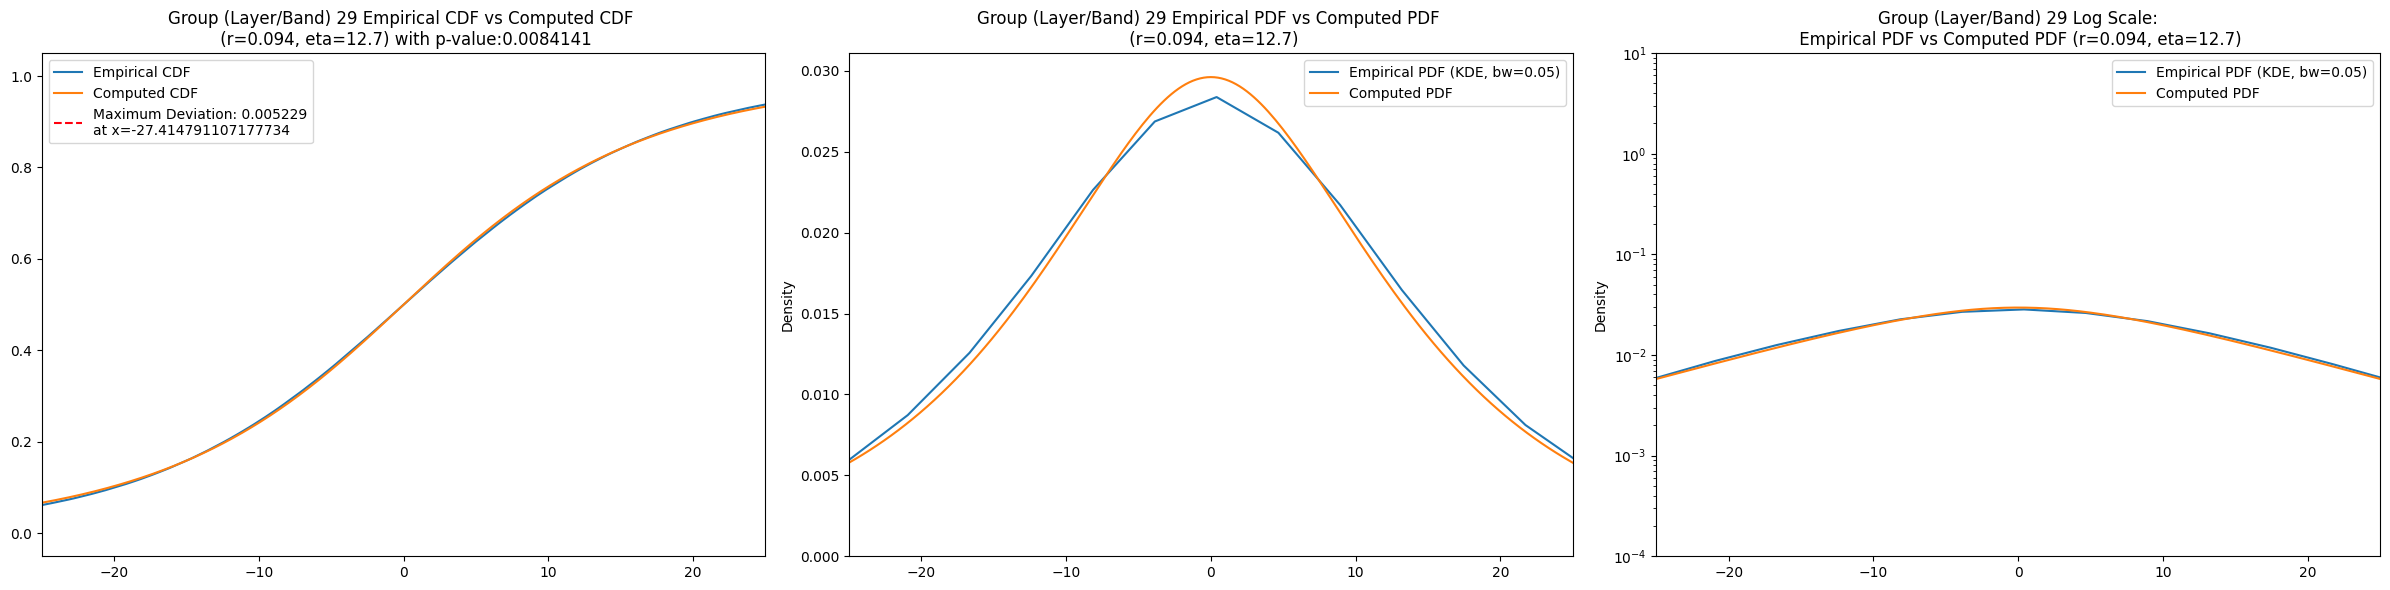

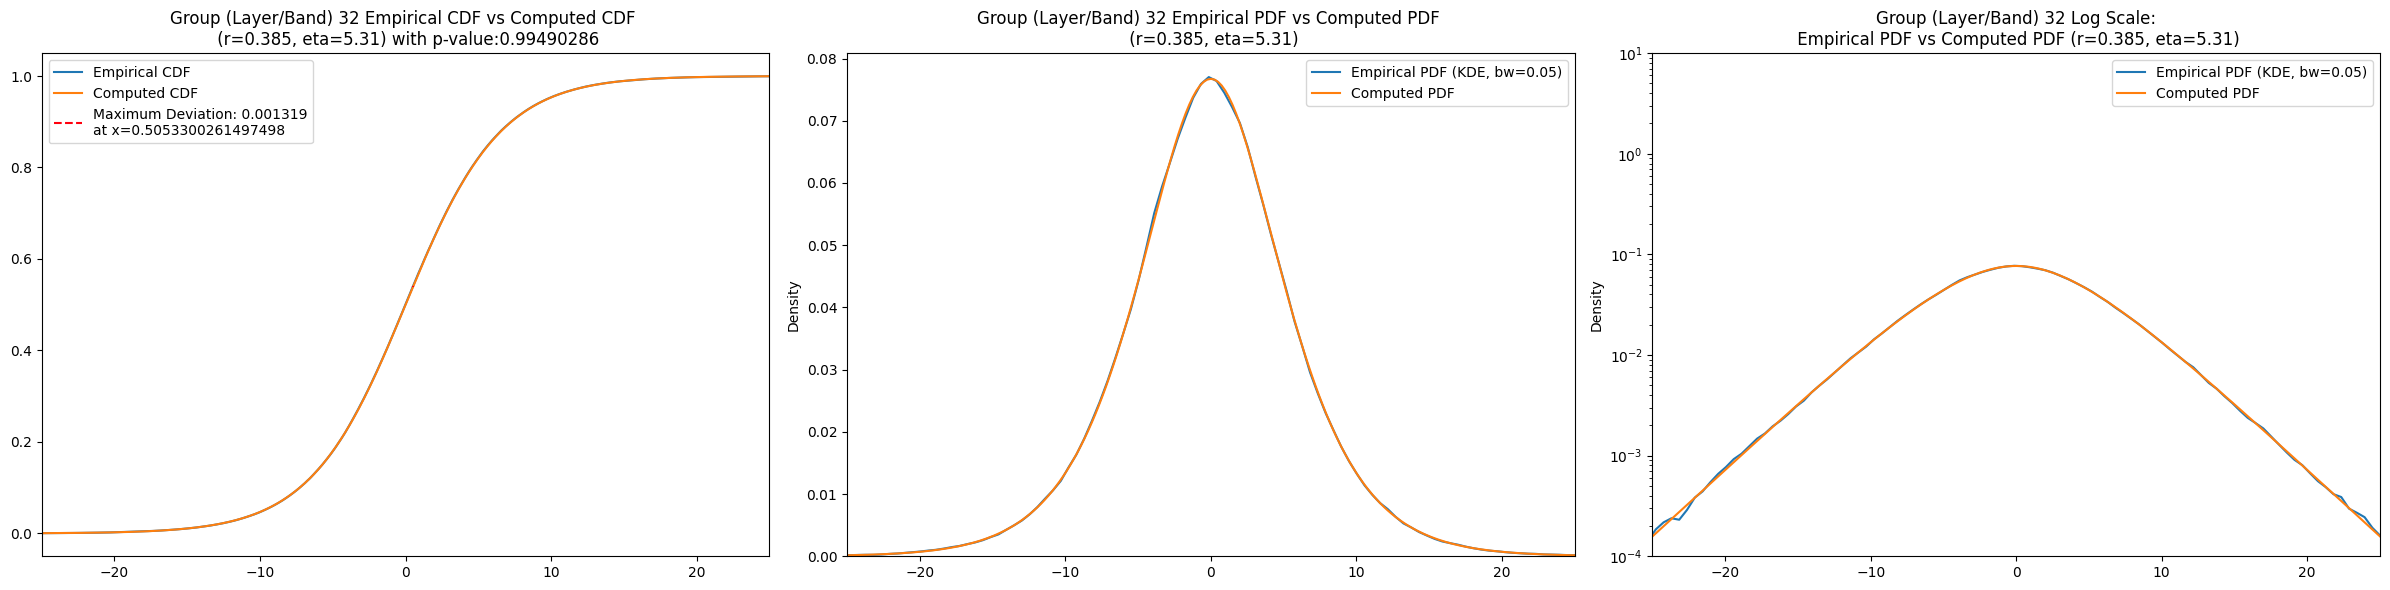

In [12]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [13]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [14]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in divide
  return bound(*args, **kwds)


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                     
2     164622.750000  156708.31000  172875.03000   1.573100    1.155113   
5      89105.410000   84883.04000   93516.57000   1.501235    1.010971   
8      49459.945000   47133.05000   51857.87000   1.475068    1.028498   
11     28516.895000   27105.72500   29987.74800   1.817942    1.125604   
14     15809.663000   15056.35000   16603.17200   1.633317    1.063960   
17      8928.170000    8495.97900    9380.36100   1.674846    1.077402   
20      4547.406700    4326.05800    4780.43460   1.779029    1.113188   
23      2160.474900    2054.57640    2273.18460   1.860174    1.162968   
26       900.715800     848.15436     965.53920   4.115283    1.578929   
29       316.848000     290.46594     357.91980  14.169542    3.107159   
32        36.040783      34.37498      37.77347   1.344013    0.882763   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       2.074450        31800.0       0.52          2.6   2.790941e+03  ...   
5       2.142560        41340.0       2.00          0.4   1.000000e+05  ...   
8       2.087626        66780.0       0.74          2.0   5.777599e+03  ...   
11      2.967208       104940.0       0.24          8.6   4.185921e-03  ...   
14      2.714023       162180.0       0.31          6.3   4.174376e-01  ...   
17      3.061004       257580.0       0.28          6.5   4.825985e-02  ...   
20      4.050655       381600.0       0.40          4.0   5.694754e+00  ...   
23      3.403249       610560.0       0.35          4.7   5.076689e-01  ...   
26     15.710218       973080.0       0.11         15.0   1.167984e-17  ...   
29     60.432312      1376940.0       0.10         12.0   1.137705e-19  ...   
32      2.353983       419760.0       0.38          5.4   1.563226e-02  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2          368.61400              0.014283          4.594620e-06   
5          275.21200              0.011832          1.865240e-05   
8          204.56900              0.011764          1.863020e-08   
11         155.62900              0.011417          2.610040e-12   
14         115.68800              0.011549          3.232950e-19   
17          86.94010              0.011910          3.632770e-32   
20          61.83360              0.011972          6.110390e-48   
23          42.53560              0.012399          5.785340e-82   
26          26.99730              0.012919         1.676710e-141   
29          15.38280              0.013266         6.721220e-211   
32           5.58052              0.010792          6.795240e-43   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         326.03700             0.017316         1.032700e-08  265.12800   
5         243.63500             0.019463         4.926660e-14  197.35600   
8         182.42700             0.020377         1.616310e-24  147.05300   
11        137.35100             0.019493         4.558230e-35  110.47800   
14        102.93600             0.019805         1.092790e-55   83.17180   
17         76.37750             0.017619         6.945100e-70   61.69150   
20         54.47950             0.017542        1.950180e-102   43.81280   
23         37.60400             0.017953        2.231290e-171   30.30130   
26         23.80450             0.017202        1.518500e-250   19.19320   
29         13.53170             0.016939         0.000000e+00   10.93770   
32          4.93339             0.019348        6.388290e-137    3.98575   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.021282   6.07511

## Results

In [15]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [16]:
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                     
2     164622.750000  156708.31000  172875.03000   1.573100    1.155113   
5      89105.410000   84883.04000   93516.57000   1.501235    1.010971   
8      49459.945000   47133.05000   51857.87000   1.475068    1.028498   
11     28516.895000   27105.72500   29987.74800   1.817942    1.125604   
14     15809.663000   15056.35000   16603.17200   1.633317    1.063960   
17      8928.170000    8495.97900    9380.36100   1.674846    1.077402   
20      4547.406700    4326.05800    4780.43460   1.779029    1.113188   
23      2160.474900    2054.57640    2273.18460   1.860174    1.162968   
26       900.715800     848.15436     965.53920   4.115283    1.578929   
29       316.848000     290.46594     357.91980  14.169542    3.107159   
32        36.040783      34.37498      37.77347   1.344013    0.882763   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       2.074450        31800.0       0.52          2.6   2.790941e+03  ...   
5       2.142560        41340.0       2.00          0.4   1.000000e+05  ...   
8       2.087626        66780.0       0.74          2.0   5.777599e+03  ...   
11      2.967208       104940.0       0.24          8.6   4.185921e-03  ...   
14      2.714023       162180.0       0.31          6.3   4.174376e-01  ...   
17      3.061004       257580.0       0.28          6.5   4.825985e-02  ...   
20      4.050655       381600.0       0.40          4.0   5.694754e+00  ...   
23      3.403249       610560.0       0.35          4.7   5.076689e-01  ...   
26     15.710218       973080.0       0.11         15.0   1.167984e-17  ...   
29     60.432312      1376940.0       0.10         12.0   1.137705e-19  ...   
32      2.353983       419760.0       0.38          5.4   1.563226e-02  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2          368.61400              0.014283          4.594620e-06   
5          275.21200              0.011832          1.865240e-05   
8          204.56900              0.011764          1.863020e-08   
11         155.62900              0.011417          2.610040e-12   
14         115.68800              0.011549          3.232950e-19   
17          86.94010              0.011910          3.632770e-32   
20          61.83360              0.011972          6.110390e-48   
23          42.53560              0.012399          5.785340e-82   
26          26.99730              0.012919         1.676710e-141   
29          15.38280              0.013266         6.721220e-211   
32           5.58052              0.010792          6.795240e-43   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         326.03700             0.017316         1.032700e-08  265.12800   
5         243.63500             0.019463         4.926660e-14  197.35600   
8         182.42700             0.020377         1.616310e-24  147.05300   
11        137.35100             0.019493         4.558230e-35  110.47800   
14        102.93600             0.019805         1.092790e-55   83.17180   
17         76.37750             0.017619         6.945100e-70   61.69150   
20         54.47950             0.017542        1.950180e-102   43.81280   
23         37.60400             0.017953        2.231290e-171   30.30130   
26         23.80450             0.017202        1.518500e-250   19.19320   
29         13.53170             0.016939         0.000000e+00   10.93770   
32          4.93339             0.019348        6.388290e-137    3.98575   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.021282   6.07511

In [17]:
remove_directory(os.path.join(CWD, "groupCDFs"))